# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on NBA player data and All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import copy
import operator
import sys
import time

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.mixture       import GaussianMixture
from sklearn.cluster       import KMeans, SpectralClustering

from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm                   import LinearSVC #, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process      import GaussianProcessClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
start = time.time()

## User input

Choose the year you want to predict, between 2010 and 2018. The years that are not selected are used for cross-validation and training of the ML algorithms.

In [3]:
test_year = 2018 # Enter any year from 2010 until 2018

print("--> Test year = {}".format(test_year))

first_year = 2010 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018
--> Train years = 2010-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played per season to be included in the analysis:

In [4]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 20 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 20


## NBA player data

NBA player data from 2010-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions in [NBAanalysissetup.py](NBAanalysissetup.py).

In [5]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target='allstar')

--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of All-Stars in *test_year*:

In [6]:
print_year = test_year

print("--> All-Stars {} :".format(print_year))
print("")
if (print_year == test_year):
    tmp = df_test[df_test['AS'] > 0.5]
else:
    tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['AS'] > 0.5)]
display(HTML(tmp.to_html()))

--> All-Stars 2018 :



Print table of non-All-Stars in *test_year*:

Select only players which have played at least *min_num_games* number of games in a season:

In [7]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[df_train['G'] >= min_num_games]
df_test  = df_test [df_test ['G'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 3775
--> # of players in test  set = 531

--> # of players in train set = 3260
--> # of players in test  set = 400


NaN handling:

In [8]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 316
--> # of players with NaNs in test  set = 22

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Check number of All-Stars in dataframes:

In [9]:
# Check All-Star data in data files:

all_years = train_years[:]
all_years.append(test_year)

n_AS_dict = {} 

for year in all_years:
    shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(year-1, year)
    n = !{shellcommand}
    n_AS_dict[year] = int(n[0]) - 1 # Don't count header
    
# Check All-Star data in dataframes:

for year in train_years:
    n_AS_df  = df_train[(df_train['YEAR'] == year) & (df_train['AS'] > 0.5)].shape[0]
    n_AS_tot = n_AS_dict[year]
    n_tot    = df_train[(df_train['YEAR'] == year)].shape[0]
    print("--> Train year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(year, n_AS_df, n_AS_tot, n_tot))
    
n_AS_df  = df_test[df_test['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[test_year]
n_tot    = df_test.shape[0]
print("--> Test  year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(test_year, n_AS_df, n_AS_tot, n_tot))

--> Train year 2010: 28 out of 28 All-Stars in analysis (Total # of players = 391)
--> Train year 2011: 24 out of 25 All-Stars in analysis (Total # of players = 399)
--> Train year 2012: 25 out of 25 All-Stars in analysis (Total # of players = 398)
--> Train year 2013: 25 out of 25 All-Stars in analysis (Total # of players = 406)
--> Train year 2014: 24 out of 25 All-Stars in analysis (Total # of players = 416)
--> Train year 2015: 28 out of 28 All-Stars in analysis (Total # of players = 423)
--> Train year 2016: 26 out of 26 All-Stars in analysis (Total # of players = 414)
--> Train year 2017: 25 out of 25 All-Stars in analysis (Total # of players = 413)
--> Test  year 2018: 28 out of 28 All-Stars in analysis (Total # of players = 400)


Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [10]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_train = df_train.drop(['AS', 'YEAR'], axis=1)
X_test  = df_test .drop(['AS', 'YEAR'], axis=1)

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0).round(2)
    X['MP'] = X['MP'].div(X['G'].values, axis=0).round(1)
    X['TW'] = X['TW'].div(82, axis=0)           .round(2)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)
    
    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_train = df_train['AS']
y_test  = df_test ['AS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_train.shape[1] # equals X_test.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))
print("")

print("--> Model features : ", list(X_train.columns))

--> Train data set : # of players = 3260, # of features = 24
--> Test  data set : # of players =  400, # of features = 24

--> Model features :  ['G', 'GS/G', 'MP/G', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW/82']


Scale feature dataframes to accommodate ML algorithms:

In [11]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test using fitted scaler

## Unsupervised Learning: PCA & Clustering

Explore features of All-Stars and non-All-Stars by plotting (some of) their distributions in training data:

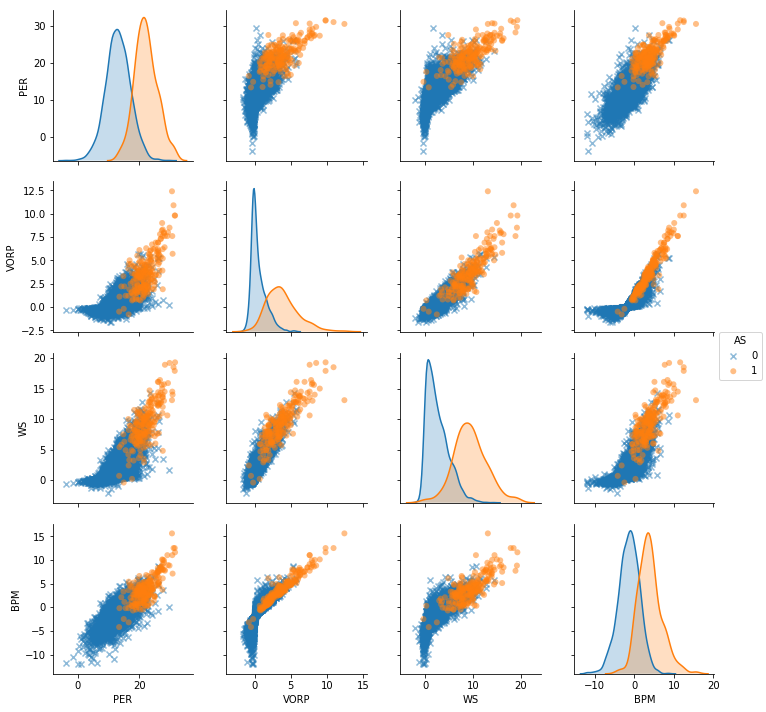

In [12]:
if includeadvancedstats:
    plotvariables = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotvariables = ['PTS', 'eFG%', 'MP']

_ = sns.pairplot(df_train, vars=plotvariables, hue="AS", diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Use Principal Component Analysis for dimensionality reduction and plot result:

--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the two
    principal axes in feature space that have maximum variance in the data:


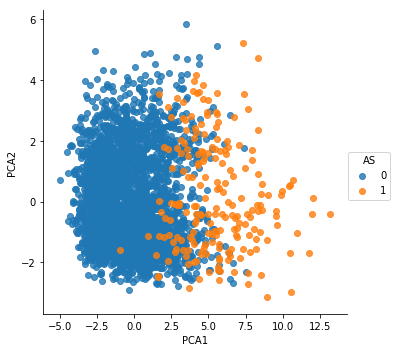

In [13]:
PCA_model = PCA(n_components=2, svd_solver='randomized') # Instantiate PCA model with hyperparameters

PCA_model.fit(X_train)                                   # Fit model to data (unsupervised: y is not specified)

X_2D = PCA_model.transform(X_train)                      # Transform the data to two PCA dimensions

df_train['PCA1'] = X_2D[:, 0] 
df_train['PCA2'] = X_2D[:, 1]

print("--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the two")
print("    principal axes in feature space that have maximum variance in the data:")

_ = sns.lmplot("PCA1", "PCA2", data=df_train, hue='AS', fit_reg=False)

Apply clustering algorithms to identify clusters in the training data and plot clusters:

--> KMeans clusters:


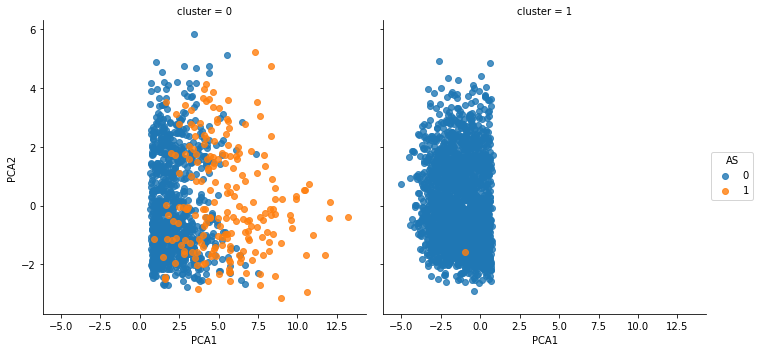

--> Gaussian Mixture clusters:


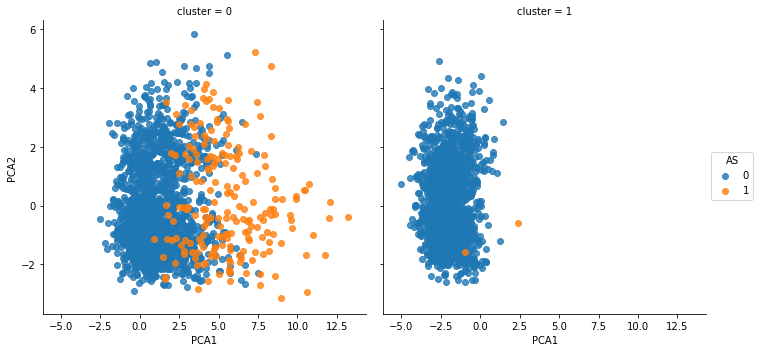

--> Spectral Clustering clusters:


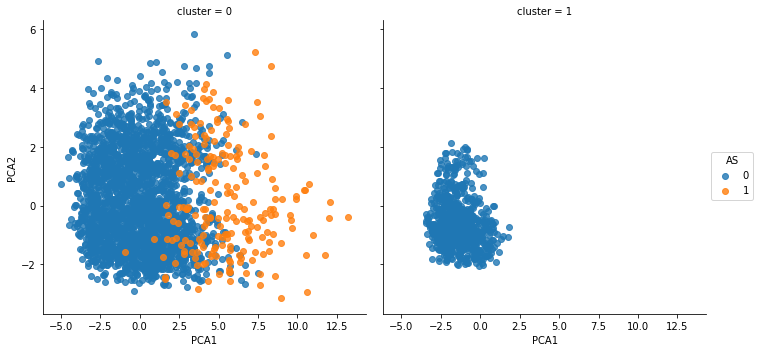

In [14]:
cluster_models = []

estimator_name = 'KMeans'
estimator = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Gaussian Mixture'
estimator = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Spectral Clustering'
estimator = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

for model in cluster_models:
                      
    model[1].fit(X_train)                                # Fit model to data (unsupervised: y is not specified)
    
    if hasattr(model[1], 'labels_'):                     # Determine cluster labels
        y_prediction = model[1].labels_.astype(np.int)
    else:
        y_prediction = model[1].predict(X_train)

    df_train['cluster'] = y_prediction

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA1", "PCA2", data=df_train, hue='AS', col='cluster', fit_reg=False)
    plt.show()

#### Conclusion: 

The unsupervised learning algorithms tested in this analysis are unable to identify the NBA All-Stars and non-All-Stars as separate clusters.

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [15]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'Nearest Neighbours Classifier'
n_n = 5
w   = 'uniform' # 'distance'
estimator = KNeighborsClassifier(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Logistic Regression Classifier'
C = 100  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
estimator = LogisticRegression(C=C, penalty=p)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Support Vector Machine Classifier'
estimator_name = 'Linear Support Vector Machine Classifier'
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#estimator = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
estimator = LinearSVC(C=C, penalty=p, dual=False)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Classifier'
l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
p = 'l2'
estimator = SGDClassifier(loss=l, penalty=p, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Quadratic Discriminant Analysis Classifier'
estimator_name = 'Linear Discriminant Analysis Classifier'
#estimator = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
estimator = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Classifier'
C = 0.001
l = 'squared_hinge' # 'hinge'
estimator = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Perceptron Classifier'
p   = 'l2' # 'l1', 'elasticnet'
a   = 0.0001 # regularization factor
m_i = 5 # maximum number of passes over the training data (aka epochs) 
estimator = Perceptron(penalty=p, alpha=a, max_iter=m_i, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Neural Network Classifier'
a = 0.0001 # regularization factor
estimator = MLPClassifier(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Process Classifier' # (CV is slowwwwwwww)
estimator = GaussianProcessClassifier(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Naive Bayes Classifier'
estimator = GaussianNB()
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Classifier'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
estimator = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Classifier'
m_d = None
m_f = 'auto'
n_e = 100
estimator = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extremely Randomized Trees Classifier'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boost Classifier'
n_e = 100
m_d = 3
l_l = 0.1
estimator = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosting Classifier'
n_e = 100
l_l = 0.1
estimator = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Bagged Decision Tree Classifier'
m_d = None
m_f = 'auto'
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
estimator = BaggingClassifier(base_estimator=dtc, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML classifiers implemented in this analysis:")
print("")

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())

--> ML classifiers implemented in this analysis:

 0 : Nearest Neighbours Classifier
 1 : Logistic Regression Classifier
 2 : Linear Support Vector Machine Classifier
 3 : Stochastic Gradient Descent Classifier
 4 : Linear Discriminant Analysis Classifier
 5 : Passive Aggressive Classifier
 6 : Perceptron Classifier
 7 : Neural Network Classifier
 8 : Gaussian Process Classifier
 9 : Gaussian Naive Bayes Classifier
10 : Decision Tree Classifier
11 : Random Forest Classifier
12 : Extremely Randomized Trees Classifier
13 : Gradient Boost Classifier
14 : Adaptive Boosting Classifier
15 : Bagged Decision Tree Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season, and calculate some classification scores:

In [16]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_scores = []

modelnames = []

for model in models:
    
    model.reset()
    
    classifier      = model.estimator
    classifier_name = model.estimator_name

    modelnames.append(classifier_name)
    
    model.YEAR_cvgroups = train_years
    
    PRE_cvgroups = []
    REC_cvgroups = []
    F1_cvgroups  = []
    ACC_cvgroups = []
    FPR_cvgroups = []

    FPR_ROC_cvgroups = []
    TPR_ROC_cvgroups = []
    AUC_ROC_cvgroups = []
    PRE_PR_cvgroups  = []
    REC_PR_cvgroups  = []
    AUC_PR_cvgroups  = []
    
    print("--> Cross-validating", classifier_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        classifier.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = classifier.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
        
        CM = MyCM(confusion_matrix(y_cvtruth, y_cvprediction))
        
        PRE_cvgroups.append(CM.precision)
        REC_cvgroups.append(CM.recall)
        F1_cvgroups .append(CM.f1)
        ACC_cvgroups.append(CM.accuracy)
        FPR_cvgroups.append(CM.fpr)

        '''
        if hasattr(classifier, 'predict_proba'):
            y_cvscore = classifier.predict_proba(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore[:, 1])
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore[:, 1])
        else:
            y_cvscore = classifier.decision_function(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)
        '''
        
        if hasattr(classifier, 'decision_function'):
            y_cvscore = classifier.decision_function(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)
        else:
            y_cvscore = classifier.predict_proba(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore[:, 1])
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore[:, 1])

        roc_auc = auc(fpr, tpr)
        pr_auc  = auc(rec, pre)
        rec = rec[::-1] # reverse list
        pre = pre[::-1] # reverse list
        
        FPR_ROC_cvgroups.append(fpr)
        TPR_ROC_cvgroups.append(tpr)
        AUC_ROC_cvgroups.append(roc_auc)
        PRE_PR_cvgroups.append(pre)
        REC_PR_cvgroups.append(rec)
        AUC_PR_cvgroups.append(pr_auc)
        
    model.PRE_cvgroups = PRE_cvgroups
    model.REC_cvgroups = REC_cvgroups
    model.F1_cvgroups  = F1_cvgroups
    model.ACC_cvgroups = ACC_cvgroups
    model.FPR_cvgroups = FPR_cvgroups

    model.FPR_ROC_cvgroups = FPR_ROC_cvgroups
    model.TPR_ROC_cvgroups = TPR_ROC_cvgroups
    model.AUC_ROC_cvgroups = AUC_ROC_cvgroups
    model.PRE_PR_cvgroups  = PRE_PR_cvgroups
    model.REC_PR_cvgroups  = REC_PR_cvgroups
    model.AUC_PR_cvgroups  = AUC_PR_cvgroups
    
    cv_scores.append({'Estimator'      : classifier_name, 
                      'Precision mean' : (np.mean(model.PRE_cvgroups)*100).round(1),
                      'Precision std'  : (np.std (model.PRE_cvgroups)*100).round(1),
                      'Recall mean'    : (np.mean(model.REC_cvgroups)*100).round(1),
                      'Recall std'     : (np.std (model.REC_cvgroups)*100).round(1),
                      'F1 mean'        : (np.mean(model.F1_cvgroups )*100).round(1),
                      'F1 std'         : (np.std (model.F1_cvgroups )*100).round(1),
                      'Accuracy mean'  : (np.mean(model.ACC_cvgroups)*100).round(1),
                      'Accuracy std'   : (np.std (model.ACC_cvgroups)*100).round(1),
                      'FPR mean'       : (np.mean(model.FPR_cvgroups)*100).round(1),
                      'FPR std'        : (np.std (model.FPR_cvgroups)*100).round(1)})
    
print("")
print("--> Classification scores for all models (mean and std over all years):")
print("")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std', 'FPR mean', 'FPR std']

df_cv_scores = pd.DataFrame(cv_scores, columns=columnorder)

display(HTML(df_cv_scores.to_html()))

--> Cross-validating Nearest Neighbours Classifier ...
--> Cross-validating Logistic Regression Classifier ...
--> Cross-validating Linear Support Vector Machine Classifier ...
--> Cross-validating Stochastic Gradient Descent Classifier ...
--> Cross-validating Linear Discriminant Analysis Classifier ...
--> Cross-validating Passive Aggressive Classifier ...
--> Cross-validating Perceptron Classifier ...
--> Cross-validating Neural Network Classifier ...
--> Cross-validating Gaussian Process Classifier ...
--> Cross-validating Gaussian Naive Bayes Classifier ...
--> Cross-validating Decision Tree Classifier ...
--> Cross-validating Random Forest Classifier ...
--> Cross-validating Extremely Randomized Trees Classifier ...
--> Cross-validating Gradient Boost Classifier ...
--> Cross-validating Adaptive Boosting Classifier ...
--> Cross-validating Bagged Decision Tree Classifier ...

--> Classification scores for all models (mean and std over all years):



 Plot the Receiver Operating Characteristic curves for all models:

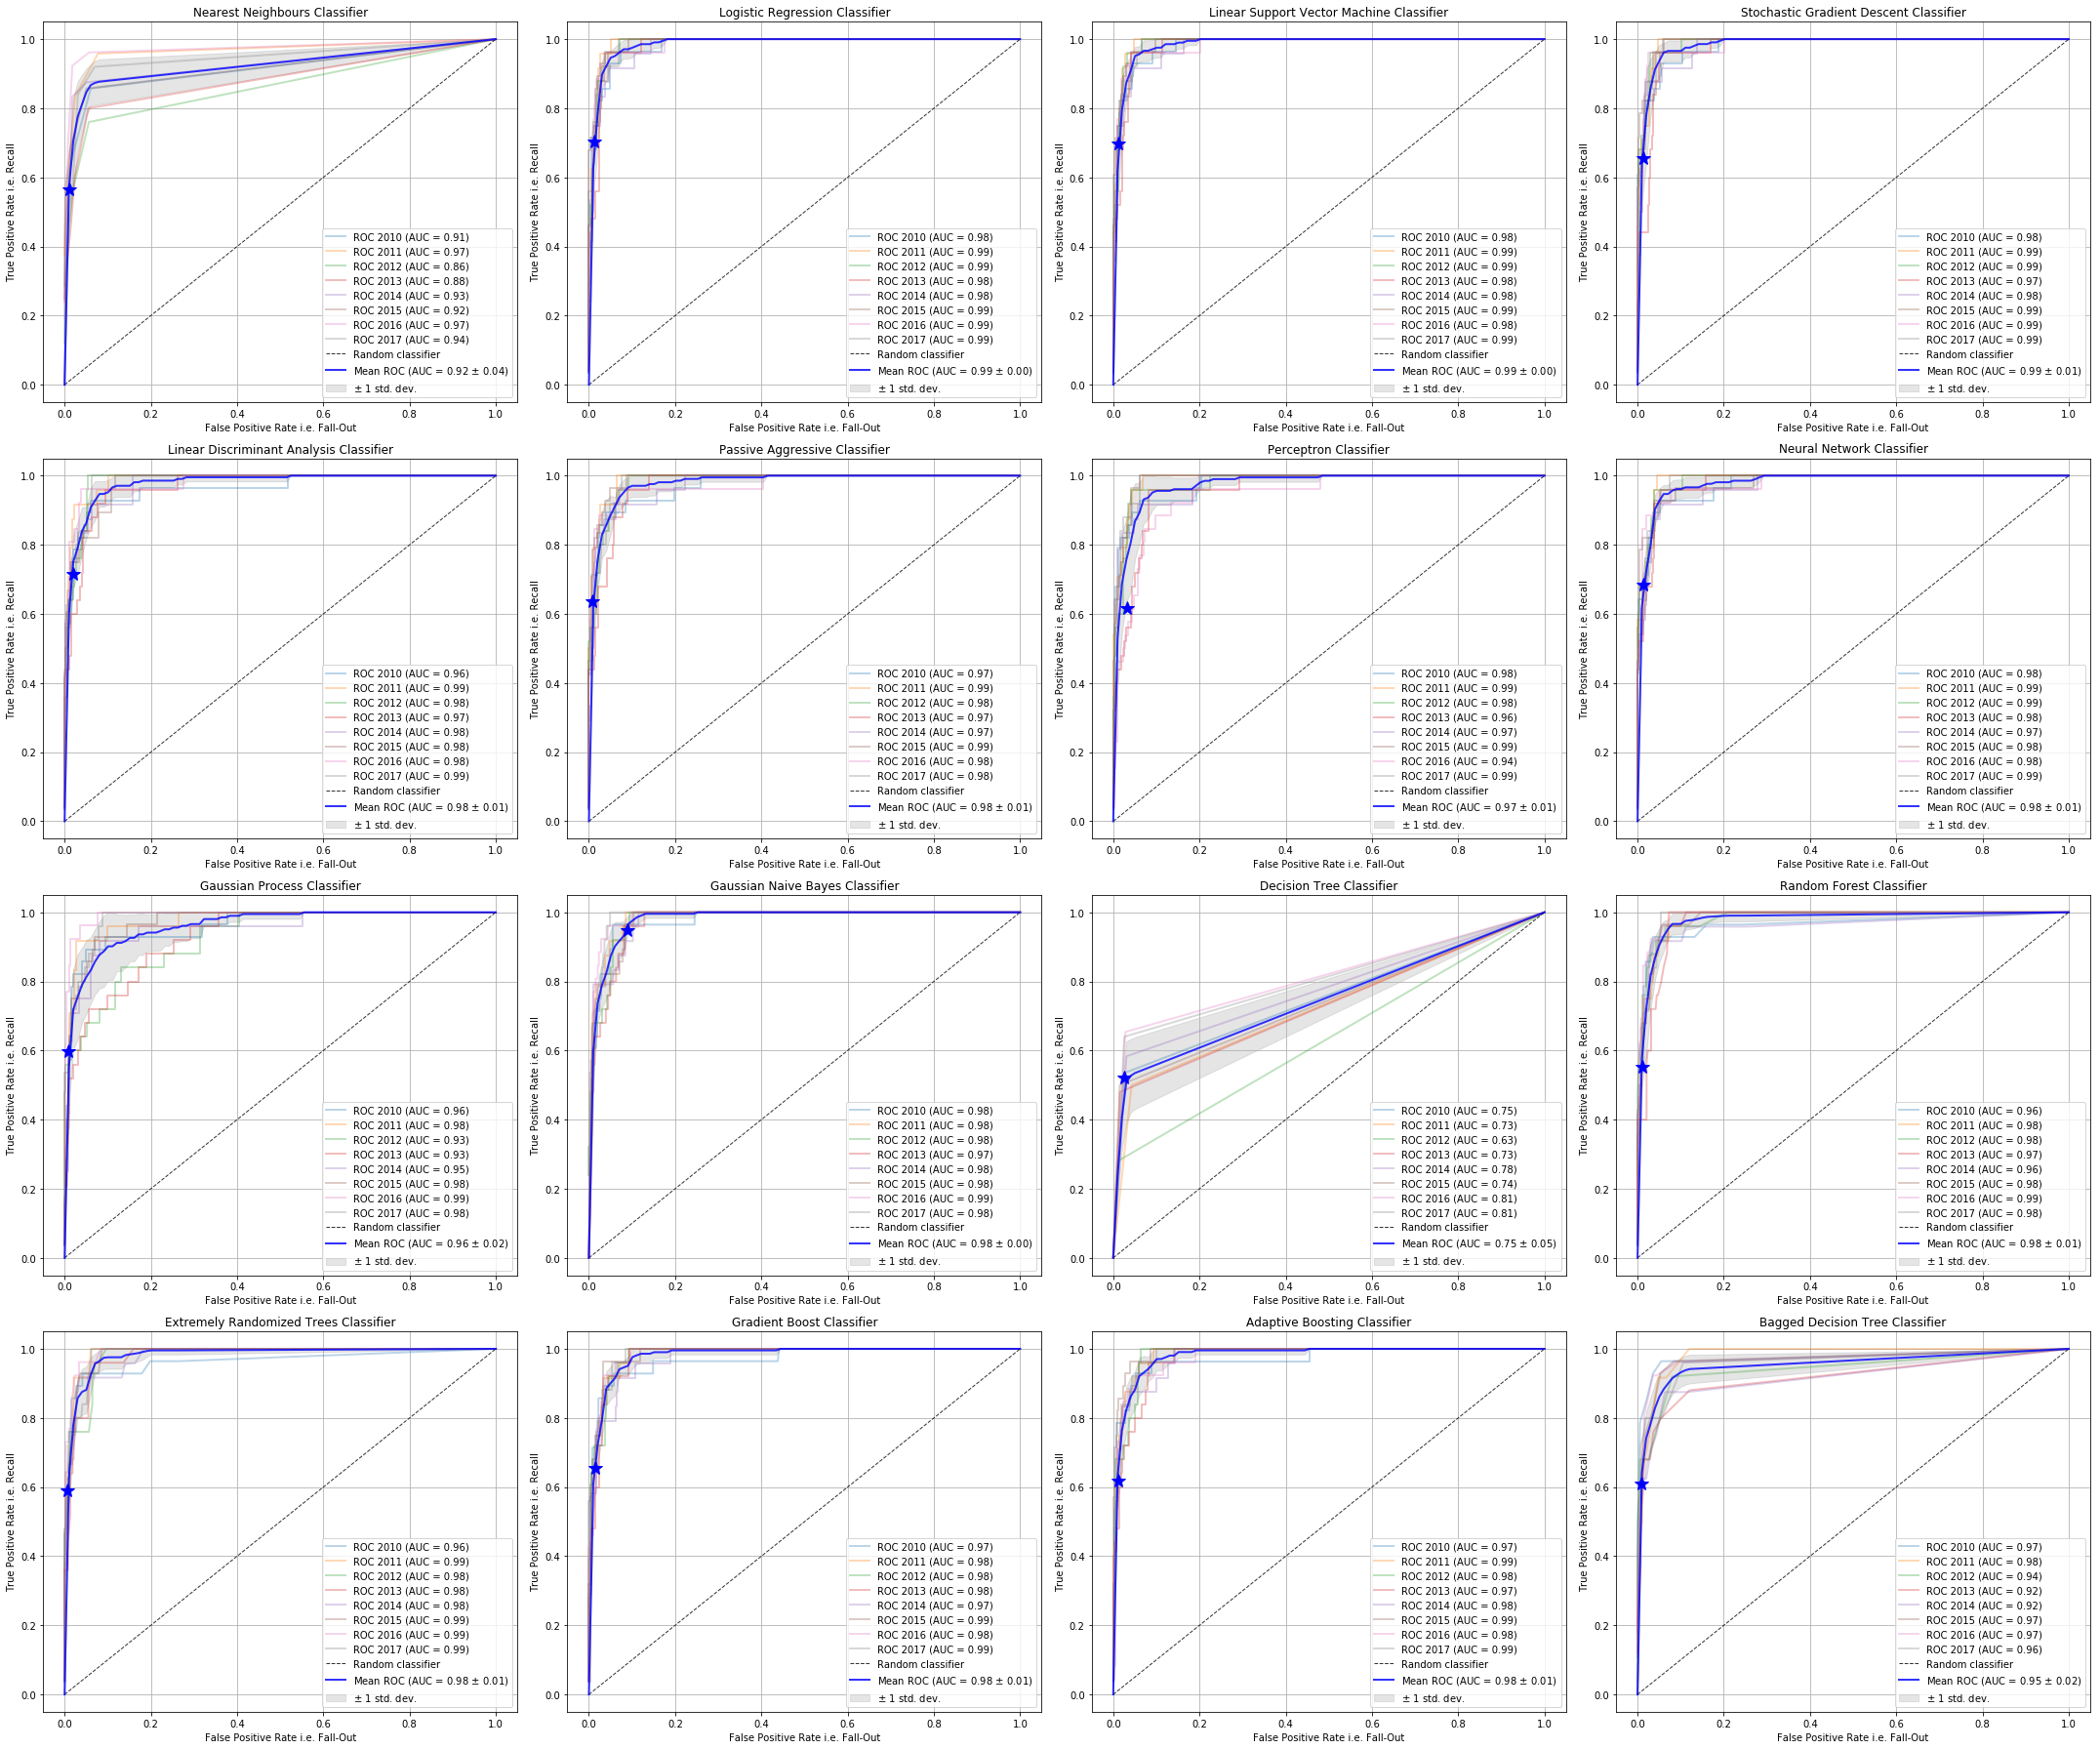

In [17]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    tpr_linspaces = []
    fpr_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        tpr_linspaces.append(np.interp(fpr_linspace, model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i]))
        tpr_linspaces[-1][0] = 0.0
        plt.plot(model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i], lw=2, alpha=0.3, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_ROC_cvgroups[i]))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color='blue', markersize=15, zorder=20)
    
    mean_tpr_linspaces = np.mean(tpr_linspaces, axis=0)
    mean_tpr_linspaces[-1] = 1.0
    plt.plot(fpr_linspace, mean_tpr_linspaces, color='blue', lw=2, alpha=.8,
             label=r"Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_ROC_cvgroups), 
                                                                    np.std(model.AUC_ROC_cvgroups)))
    model.fpr_linspace       = fpr_linspace
    model.mean_tpr_linspaces = mean_tpr_linspaces
    
    std_tpr_linspaces = np.std(tpr_linspaces, axis=0)
    tpr_linspaces_upper = np.minimum(mean_tpr_linspaces + std_tpr_linspaces, 1)
    tpr_linspaces_lower = np.maximum(mean_tpr_linspaces - std_tpr_linspaces, 0)
    plt.fill_between(fpr_linspace, tpr_linspaces_lower, tpr_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate i.e. Fall-Out")
    plt.ylabel("True Positive Rate i.e. Recall")
    plt.title(model.estimator_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

 Plot the Precision-Recall curves for all models:

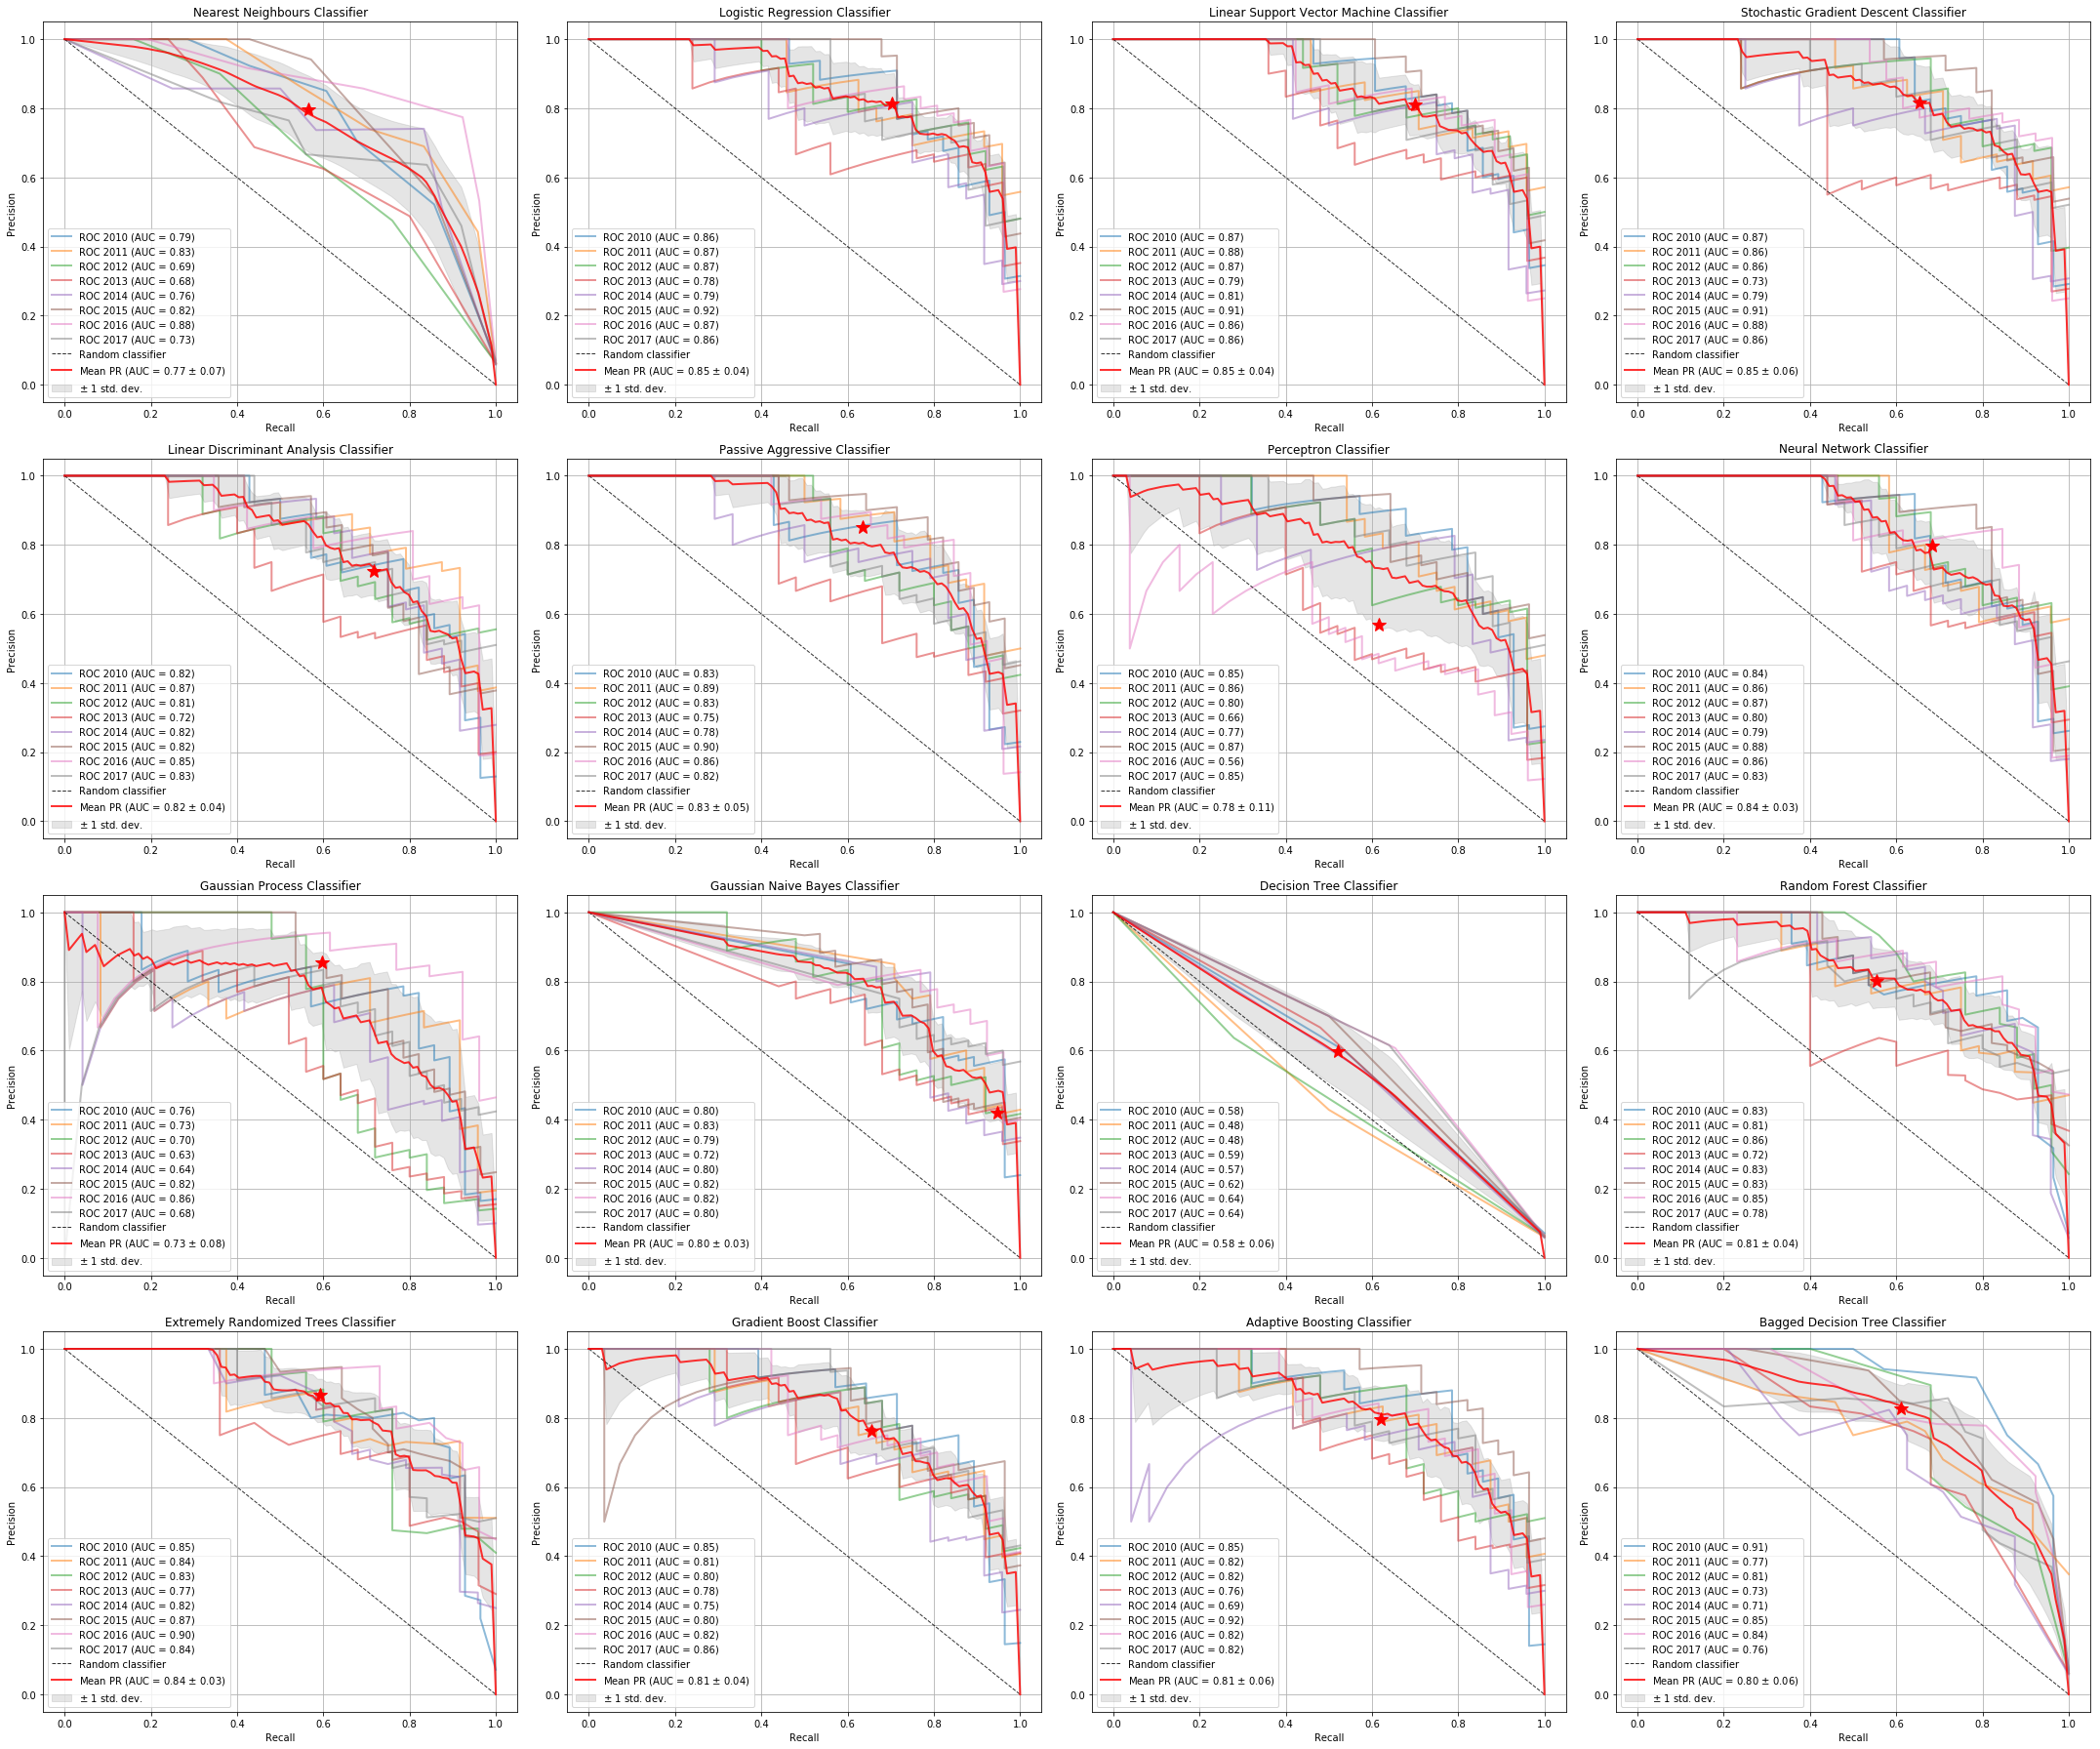

In [18]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    pre_linspaces = []
    rec_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        pre_linspaces.append(np.interp(rec_linspace, model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i]))
        pre_linspaces[-1][0] = 1.0
        plt.plot(model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i], lw=2, alpha=0.5, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_PR_cvgroups[i]))
        
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups), 
             marker='*', color='red', markersize=15, zorder=20)
    
    mean_pre_linspaces = np.mean(pre_linspaces, axis=0)
    mean_pre_linspaces[-1] = 0.0
    plt.plot(rec_linspace, mean_pre_linspaces, color='red', lw=2, alpha=.8,
             label=r"Mean PR (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_PR_cvgroups), 
                                                                    np.std(model.AUC_PR_cvgroups)))
    model.rec_linspace       = rec_linspace
    model.mean_pre_linspaces = mean_pre_linspaces

    std_pre_linspaces = np.std(pre_linspaces, axis=0)
    pre_linspaces_upper = np.minimum(mean_pre_linspaces + std_pre_linspaces, 1)
    pre_linspaces_lower = np.maximum(mean_pre_linspaces - std_pre_linspaces, 0)
    plt.fill_between(rec_linspace, pre_linspaces_lower, pre_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(model.estimator_name)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()

Plot the mean ROC and PR curves for all models in single plots for comparison:

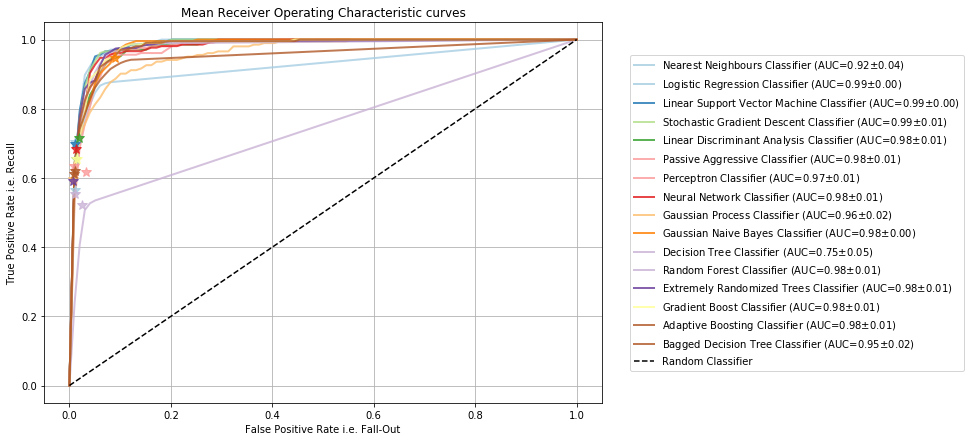

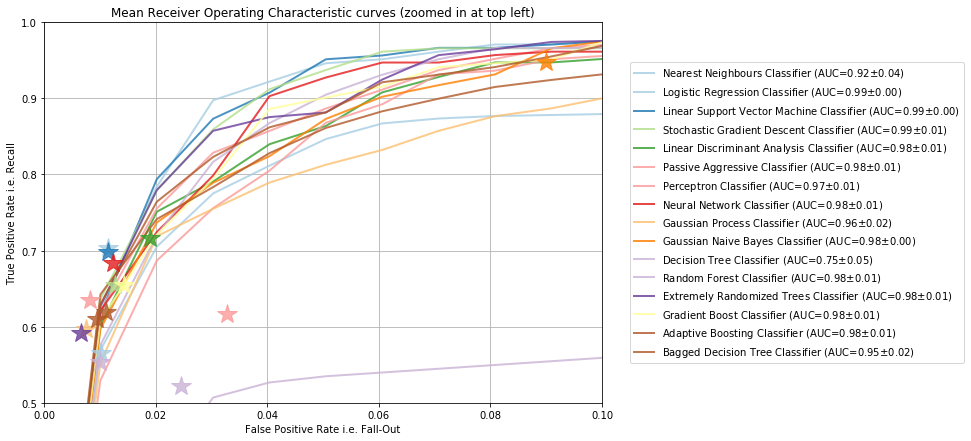

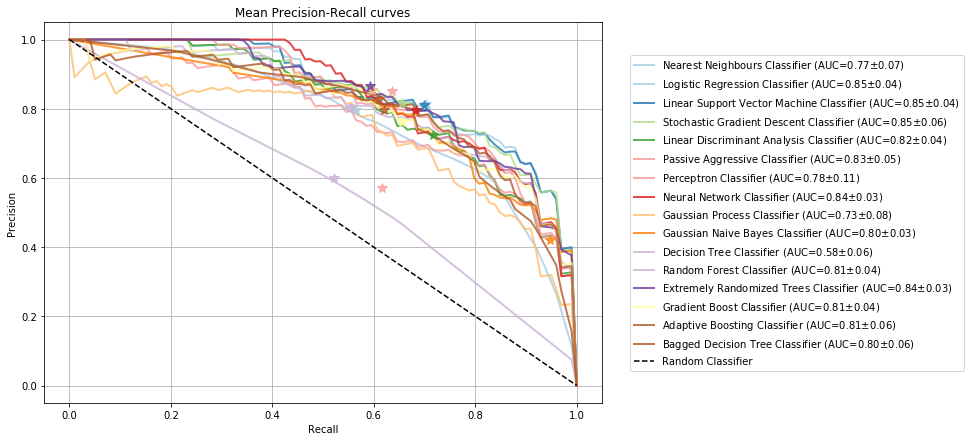

In [19]:
color = iter(plt.cm.Paired(np.linspace(0, 1, len(models))))

plt.figure(1, figsize=(10, 7))
plt.figure(2, figsize=(10, 7))
plt.figure(3, figsize=(10, 7))

for model in models:

    c=next(color)
        
    plt.figure(1)
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_ROC_cvgroups), 
                                                np.std(model.AUC_ROC_cvgroups))
    plt.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)
    
    plt.figure(2)
    plt.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups),
             marker='*', color=c, alpha=.8, markersize=20, zorder=20)

    plt.figure(3)
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_PR_cvgroups), 
                                                np.std(model.AUC_PR_cvgroups))
    plt.plot(model.rec_linspace, model.mean_pre_linspaces, color=c, lw=2, alpha=.8, label=label)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups),
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)

plt.figure(1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Mean Receiver Operating Characteristic curves')
#plt.legend(loc="lower right")
plt.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
plt.grid(True)

plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.5, 1)
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Mean Receiver Operating Characteristic curves (zoomed in at top left)')
#plt.legend(loc="lower right")
plt.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
plt.grid(True)

plt.figure(3)
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall curves')
#plt.legend(loc="lower left")
plt.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
plt.grid(True)

#### Conclusion: 

The cross-validation metrics indicate that almost all ML classifiers included in this analysis are stable and have a reasonable performance, e.g. precision scores are 70-80%, recall scores are 60-70%. Exceptions are
- **Gaussian Naive Bayes Classifier**: This model is too 'loose', i.e. the recall score is very high but the precision score is very low. 
- **Perceptron Classifier**: Less powerful model than the others.
- **Decision Tree Classifier**: Less powerful model than the others.


In [20]:
rejected_models = [6, 9, 10] # i.e. Perceptron, GNB, DT

## Model training and predictions

Fit all models to training data and use fitted models to predict the NBA All-Stars from *test_year*:

In [21]:
scores_list = []

for model in models:
    
    classifier = model.estimator

    print("--> Fitting", model.estimator_name, "...")
    
    classifier.fit(X_train, y_train)          # Fit model to training data

    y_prediction = classifier.predict(X_test) # Predict test data
    model.set_y_prediction(y_prediction)
    
    y_truth = y_test.tolist()
    model.set_y_truth(y_truth)
    
    CM = confusion_matrix(y_truth, y_prediction) # defined as: rows -> truth, columns -> prediction
    model.set_CM(CM)
    
    scores_list.append({'Estimator' : model.estimator_name, 
                        'TP'        : model.CM.TP, 
                        'FP'        : model.CM.FP, 
                        'FN'        : model.CM.FN, 
                        'TN'        : model.CM.TN, 
                        'Precision' : model.CM.precision.round(3)*100, 
                        'Recall'    : model.CM.recall.round(3)*100, 
                        'F1'        : model.CM.f1.round(3)*100, 
                        'Accuracy'  : model.CM.accuracy.round(3)*100,
                        'FPR'       : model.CM.fpr.round(3)*100})
    '''
    print("")
    print("--> Confusion matrix {}:".format(test_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_test, y_prediction)
    recall    = recall_score   (y_test, y_prediction)
    f1        = f1_score       (y_test, y_prediction)
    accuracy  = accuracy_score (y_test, y_prediction)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

print("")
print("--> Classification scores of all models for", test_year, ":")
print("")
    
columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'FPR']

df_scores = pd.DataFrame(scores_list, columns=columnorder)

display(HTML(df_scores.to_html()))

--> Fitting Nearest Neighbours Classifier ...
--> Fitting Logistic Regression Classifier ...
--> Fitting Linear Support Vector Machine Classifier ...
--> Fitting Stochastic Gradient Descent Classifier ...
--> Fitting Linear Discriminant Analysis Classifier ...
--> Fitting Passive Aggressive Classifier ...
--> Fitting Perceptron Classifier ...
--> Fitting Neural Network Classifier ...
--> Fitting Gaussian Process Classifier ...
--> Fitting Gaussian Naive Bayes Classifier ...
--> Fitting Decision Tree Classifier ...
--> Fitting Random Forest Classifier ...
--> Fitting Extremely Randomized Trees Classifier ...
--> Fitting Gradient Boost Classifier ...
--> Fitting Adaptive Boosting Classifier ...
--> Fitting Bagged Decision Tree Classifier ...

--> Classification scores of all models for 2018 :



Plot Confusion Matrices for all fitted models:

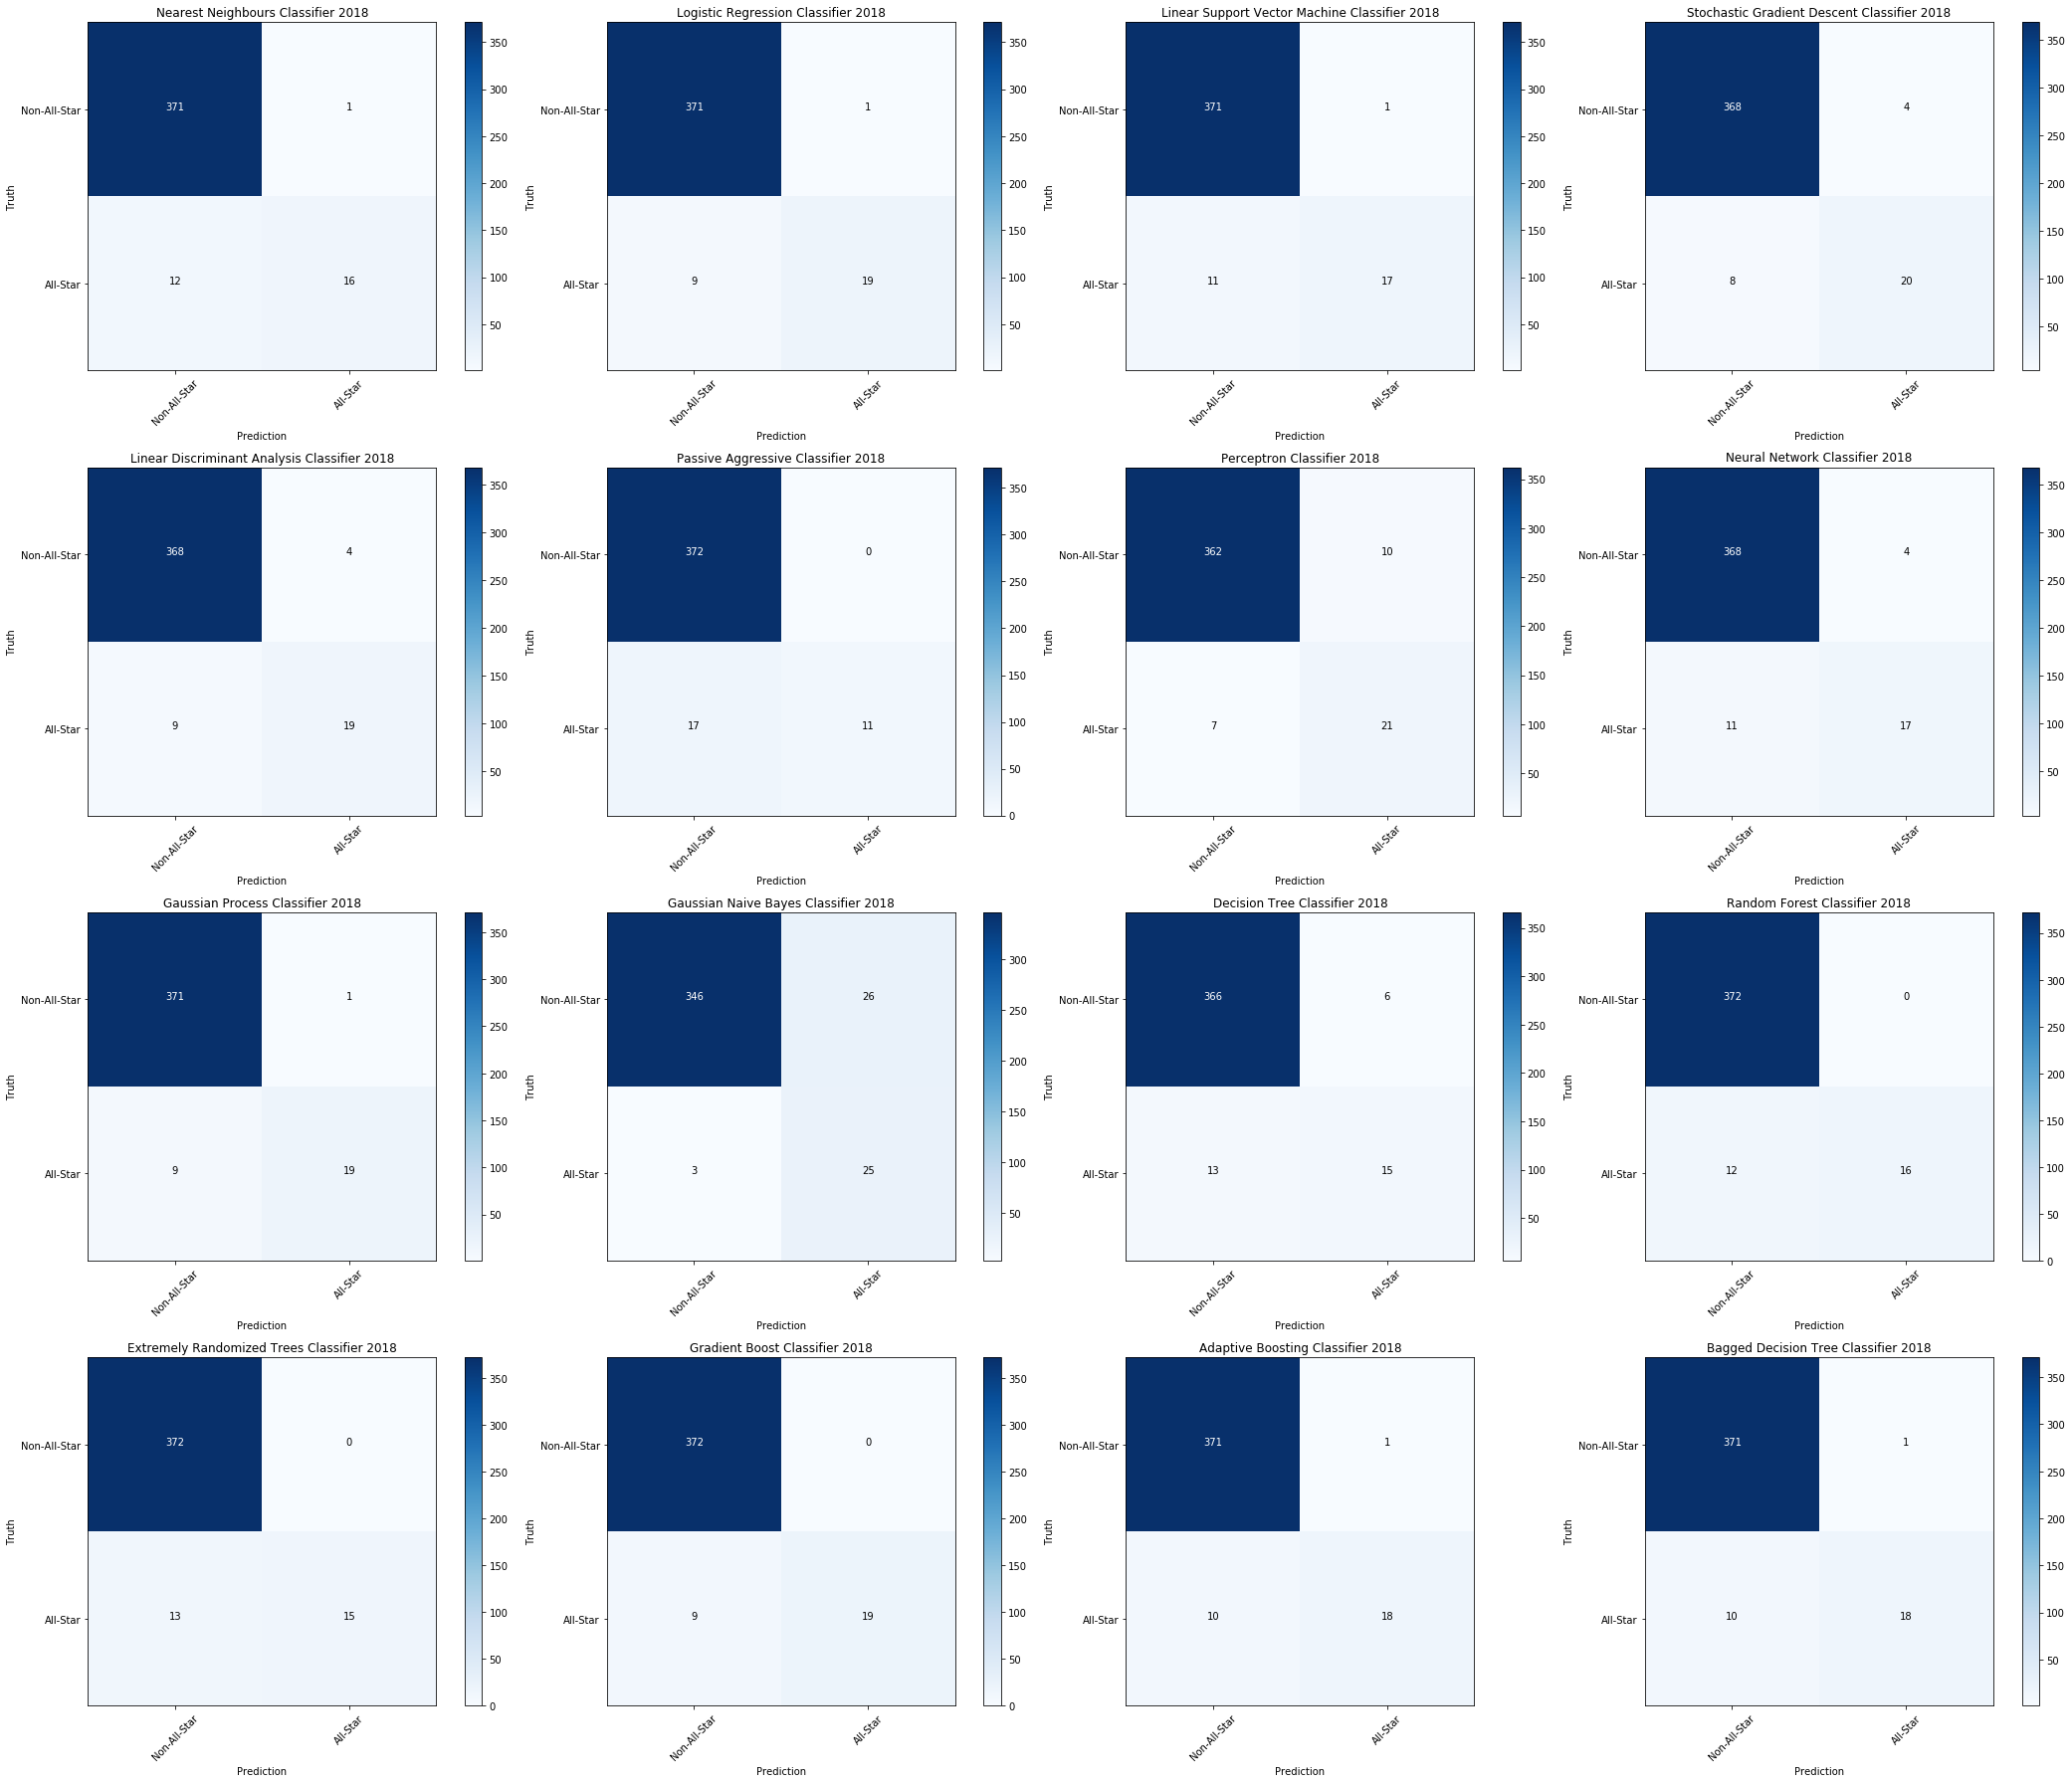

In [22]:
np.set_printoptions(precision=2)

class_names = ['Non-All-Star','All-Star']

plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    CM = confusion_matrix(model.y_truth, model.y_prediction)

    NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=False,
                                           title="{} {}".format(model.estimator_name, test_year))
    plt.tight_layout()

Print classification reports for all fitted models:

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [23]:
df_importances = pd.DataFrame(columns=modelnames, index=feature_names)

for model in models:

    print("--> Calculating feature importances for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "feature_importances_"):
    
        importances = model.estimator.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(n_features):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, feature_names[indices[i]], importances[indices[i]]))
            df_importances.loc[feature_names[i], model.estimator_name] = (importances[i]*100).round(1)
        
        #print("")
        
print("")
print("--> Feature importances of all models:")
print("")

display(HTML(df_importances.to_html()))

--> Calculating feature importances for Nearest Neighbours Classifier ...
--> Calculating feature importances for Logistic Regression Classifier ...
--> Calculating feature importances for Linear Support Vector Machine Classifier ...
--> Calculating feature importances for Stochastic Gradient Descent Classifier ...
--> Calculating feature importances for Linear Discriminant Analysis Classifier ...
--> Calculating feature importances for Passive Aggressive Classifier ...
--> Calculating feature importances for Perceptron Classifier ...
--> Calculating feature importances for Neural Network Classifier ...
--> Calculating feature importances for Gaussian Process Classifier ...
--> Calculating feature importances for Gaussian Naive Bayes Classifier ...
--> Calculating feature importances for Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extremely Randomized Trees Classifier ...
--> Calculating featu

Calculate feature coefficients of all fitted linear models (e.g. Logistic Regression):

In [24]:
df_coefficients = pd.DataFrame(columns=modelnames, index=feature_names)

for model in models:

    print("--> Calculating feature coefficients for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "coef_"):
    
        coefficients = model.estimator.coef_.ravel()
    
        #for feature_name, coefficient in zip(feature_names, coefficients):
        #    print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, coefficient))
        
        for i in range(n_features):
            df_coefficients.loc[feature_names[i], model.estimator_name] = coefficients[i].round(2)
        
        #print("")
        
print("")
print("--> Feature coefficients of all models:")
print("")

display(HTML(df_coefficients.to_html()))

--> Calculating feature coefficients for Nearest Neighbours Classifier ...
--> Calculating feature coefficients for Logistic Regression Classifier ...
--> Calculating feature coefficients for Linear Support Vector Machine Classifier ...
--> Calculating feature coefficients for Stochastic Gradient Descent Classifier ...
--> Calculating feature coefficients for Linear Discriminant Analysis Classifier ...
--> Calculating feature coefficients for Passive Aggressive Classifier ...
--> Calculating feature coefficients for Perceptron Classifier ...
--> Calculating feature coefficients for Neural Network Classifier ...
--> Calculating feature coefficients for Gaussian Process Classifier ...
--> Calculating feature coefficients for Gaussian Naive Bayes Classifier ...
--> Calculating feature coefficients for Decision Tree Classifier ...
--> Calculating feature coefficients for Random Forest Classifier ...
--> Calculating feature coefficients for Extremely Randomized Trees Classifier ...
--> Calc

Plot Logistic Curves for each feature for the fitted Logistic Regression Classifier:

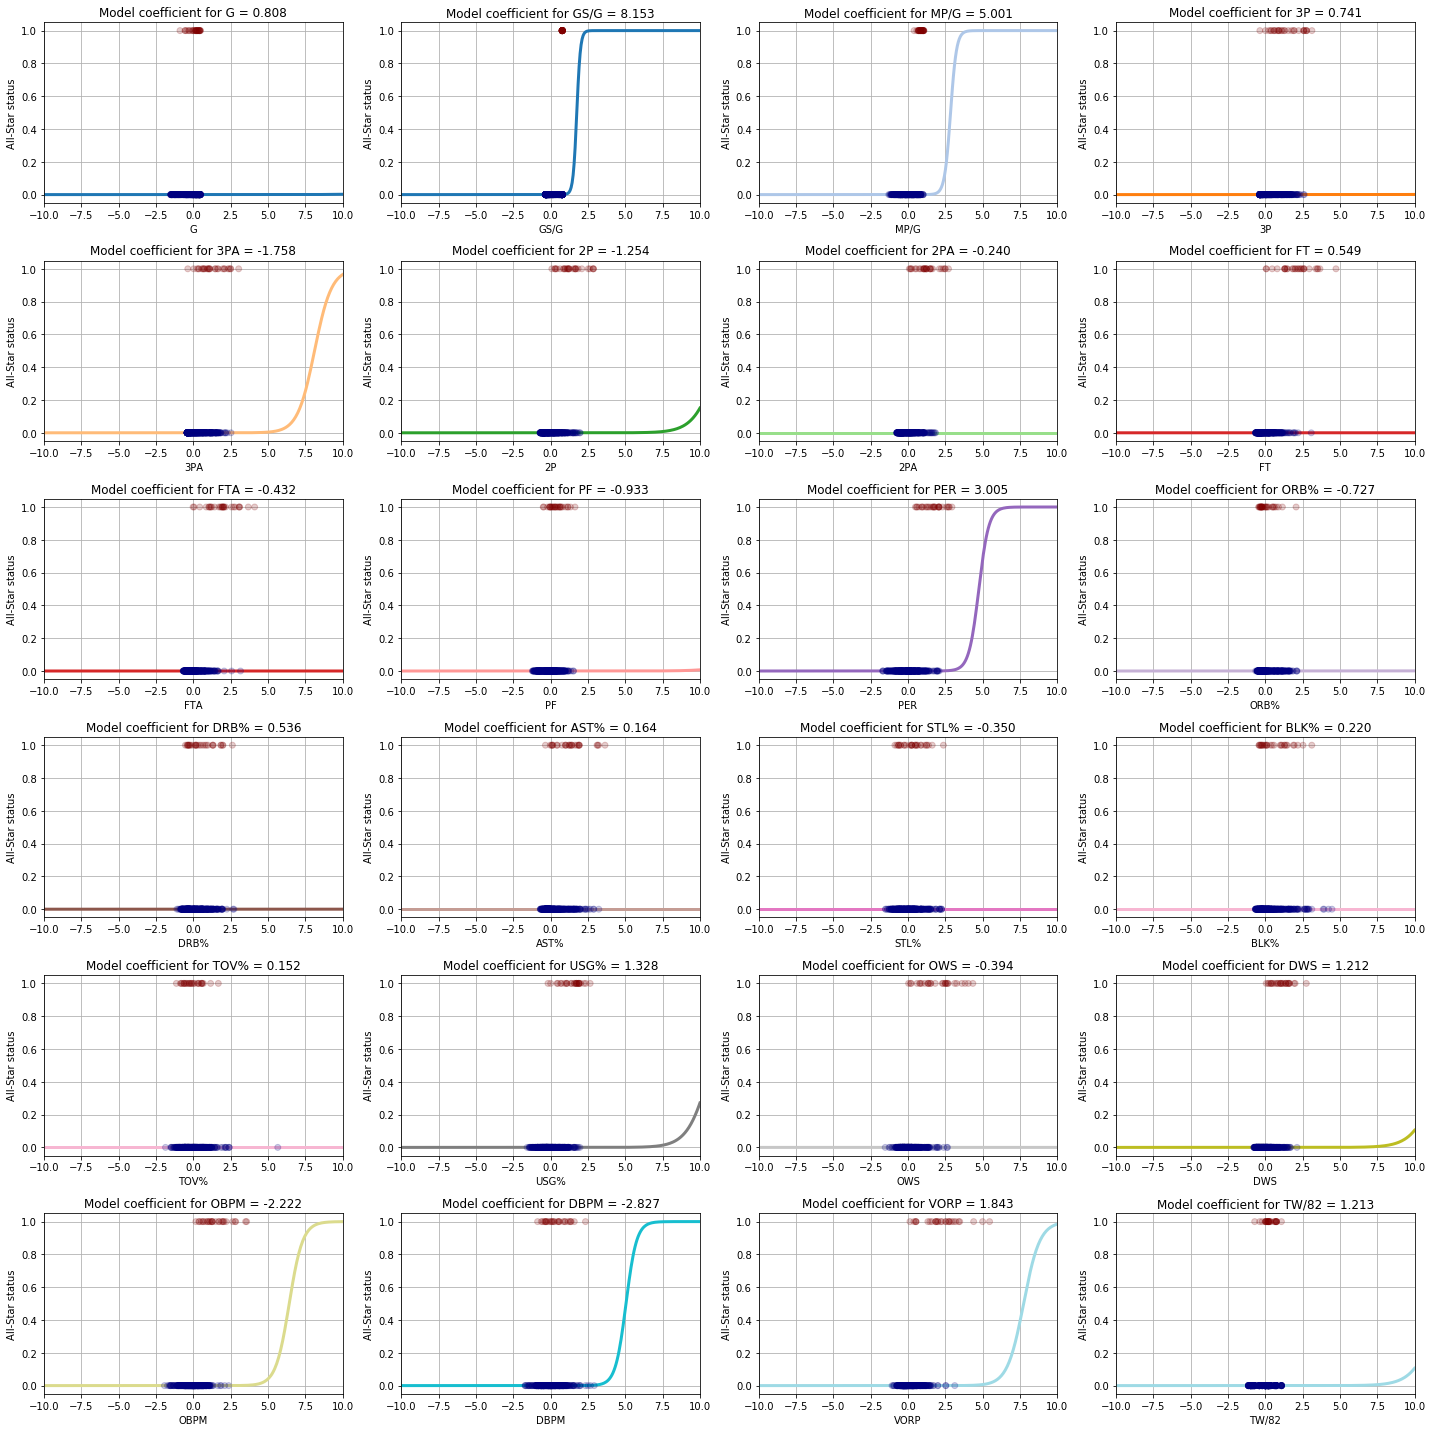

In [25]:
model = models[1].estimator # Logistic Regression Classifier

color=iter(plt.cm.tab20(np.linspace(0, 1, 24)))    

feature_linspace = np.linspace(-10, 10, 300)

plt.figure(figsize=(20, 20))

for i, (feature_name, coefficient) in enumerate(zip(feature_names, model.coef_.ravel())):
    
    plt.subplot(6, 4, i+1)

    feature_data  = X_test[:,i]
    ASstatus_data = y_test.ravel()
    
    plt.scatter(feature_data, ASstatus_data, c=ASstatus_data, cmap='jet', alpha=.2, zorder=20)
        
    logfunc = NBAanalysissetup.logistic_function(feature_linspace*abs(coefficient) + model.intercept_).ravel()

    plt.plot(feature_linspace, logfunc, color=next(color), linewidth=3, label=feature_name)

    plt.xlim([-10, 10])
    plt.ylim([-0.05, 1.05])
    plt.title("Model coefficient for {} = {:.3f}".format(feature_name, coefficient))
    plt.xlabel(feature_name)
    plt.ylabel('All-Star status')
    plt.grid(True)
    plt.tight_layout()

Plot decision function values / probability scores in 2-D feature space for all models:

Data features: G, GS/G, MP/G, 3P, 3PA, 2P, 2PA, FT, FTA, PF, PER, ORB%, DRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, OBPM, DBPM, VORP, TW/82, PCA1, PCA2


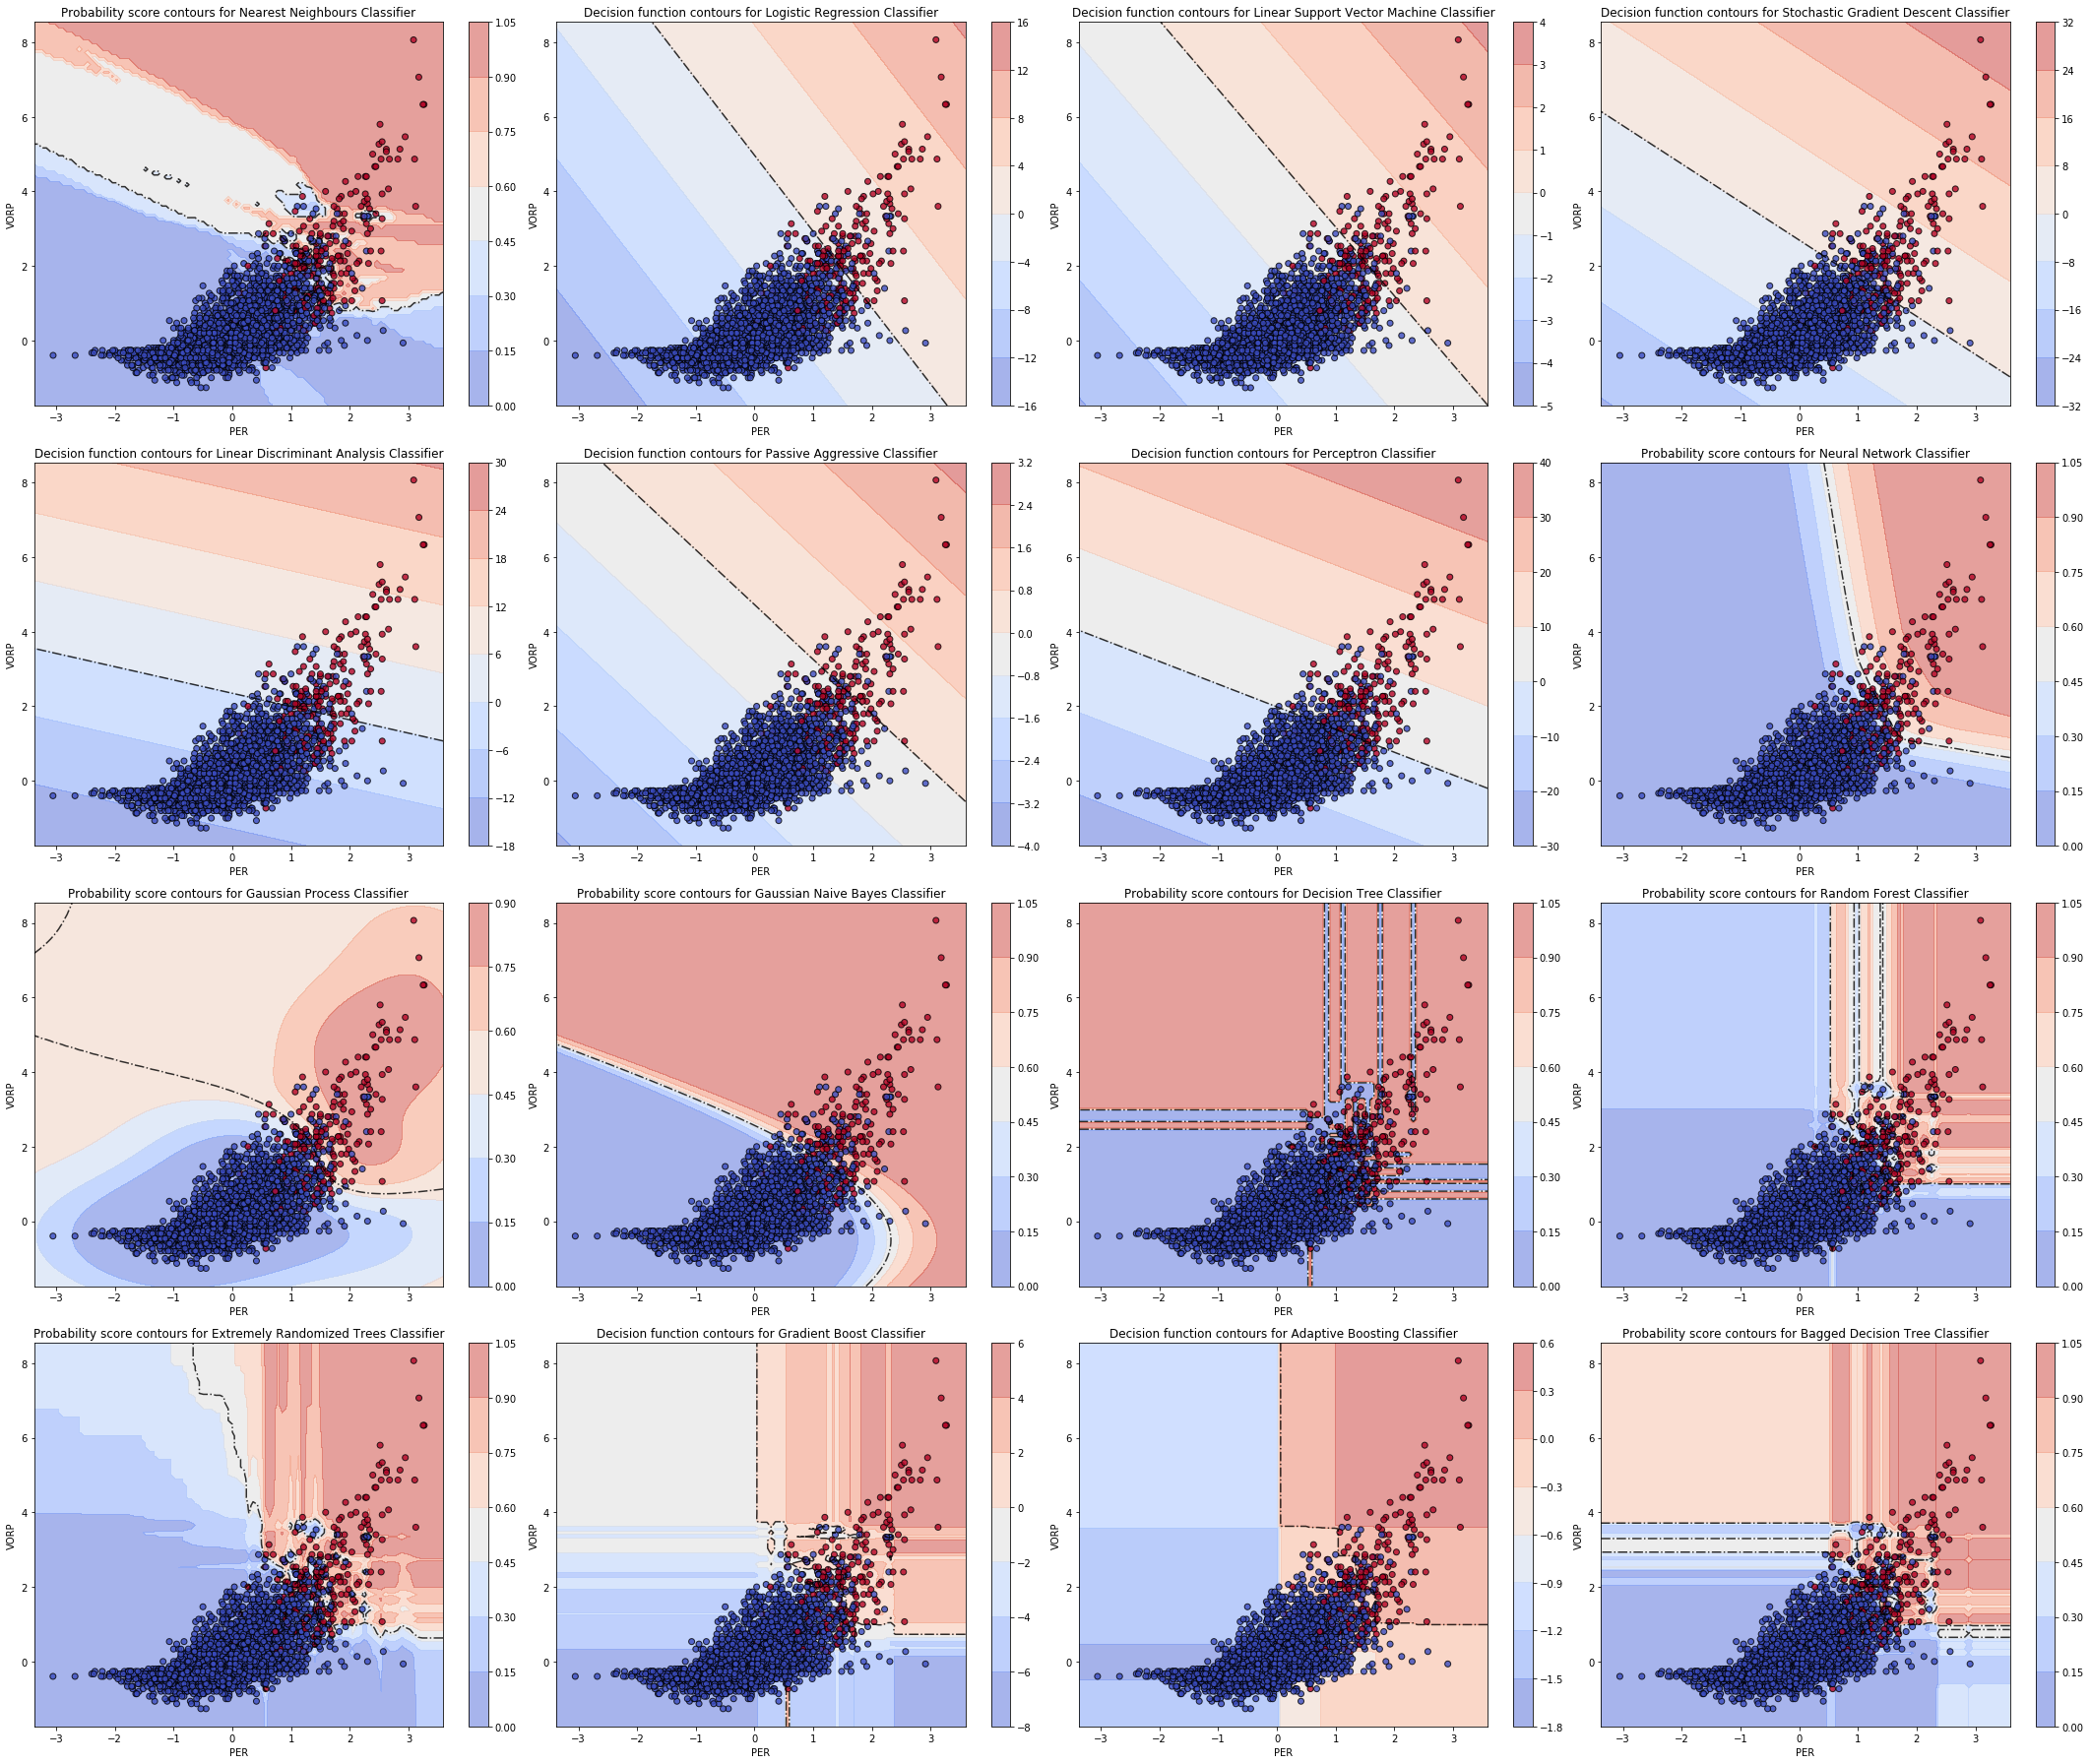

In [26]:
# Create numpy array with original data features and PCA variables:

X_tmp = np.c_[X_train, X_2D[:, 0], X_2D[:, 1]]

feature_names_list = list(feature_names)
feature_names_list.append('PCA1')
feature_names_list.append('PCA2')

# Choose two features to explore:

print("Data features: ", end='')
print(*feature_names_list, sep=", ")

if (includeadvancedstats):
    feature_x = 10 # i.e. PER
    feature_y = 22 # i.e. VORP
    #feature_x = 24 # i.e. PCA1
    #feature_y = 25 # i.e. PCA2
else:
    feature_x = 5 # i.e. 2P
    feature_y = 7 # i.e. FT
    #feature_x = 17 # i.e. PCA1
    #feature_y = 18 # i.e. PCA2

# Create 2-D array of chosen features:

X_tmp = X_tmp[:, [feature_x, feature_y]]

# Loop over all models:

plt.figure(figsize=(30,25))

colormap = plt.cm.coolwarm

for i, model in enumerate(models, 1):

    plt.subplot(4, 4, i)    
    
    # Create a copy of the classifier, and fit using 2-D features array:
        
    classifier = copy.deepcopy(model.estimator)

    classifier.fit(X_tmp, y_train)

    # Plot data:
    
    plt.scatter(X_tmp[:, 0], X_tmp[:, 1], c=y_train, 
                cmap=colormap, edgecolors='k', marker='o', alpha=0.8)

    # Create grid to calculate the decision function / probability score of the model:

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[XX.ravel(), YY.ravel()])
        title = "Decision function contours for {}".format(model.estimator_name)
        boundary = 0
    else:
        Z = classifier.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:, 1]
        title = "Probability score contours for {}".format(model.estimator_name)
        boundary = 0.5
    Z = Z.reshape(XX.shape)
    
    # Plot decision function contours and boundary:

    cf = plt.contourf(XX, YY, Z, cmap=colormap, alpha=.5, zorder=0)
    plt.colorbar(cf)
    plt.contour(XX, YY, Z, colors='black', levels=[boundary], alpha=0.8, linestyles=['-.'])

    plt.title(title)
    plt.xlabel(feature_names_list[feature_x])
    plt.ylabel(feature_names_list[feature_y])
    plt.tight_layout()

Check which players are All-Stars according to each fitted model:

In [27]:
for model in models:

    y_prediction = model.y_prediction
    y_truth      = model.y_truth
    
    print("==> Checking which players are All-Stars in {} according to {} ...".format(test_year, 
                                                                                      model.estimator_name))
    print("")

    TN_players = []
    FP_players = []
    FN_players = []
    TP_players = []
    
    for i in range(n_players_test):
    
        player_name = df_test.iat[i,0] # 0-th column in df is player name
    
        if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
            TN_players.append(player_name)
        elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
            FP_players.append(player_name)
        elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
            FN_players.append(player_name)
        else:                                                # TP
            TP_players.append(player_name)
        
    print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
    print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
    print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
    print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
    print("")
    print("--> Deserved All-Stars     : ", end='')
    print(*TP_players, sep=', ')
    print("")
    print("--> Questionable All-Stars : ", end='')
    print(*FN_players, sep=', ')
    print("")
    print("--> Snubbed non-All-Stars  : ", end='')
    print(*FP_players, sep=', ')
    print("")

==> Checking which players are All-Stars in 2018 according to Nearest Neighbours Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  16 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  12 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   1 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 371 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Anthony Davis, DeMar DeRozan, Andre Drummond, Kevin Durant, Joel Embiid, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Kevin Love, Karl-Anthony Towns, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Stephen Curry, Goran Dragic, Paul George, Draymond Green, Al Horford, Kyle Lowry, Victor Oladipo, Kristaps Porzingis, Klay Thompson, Kemba Walker, John Wall

--> Snubbed non-All-Stars  : Blake Griffin

==> Checking which players are All-Stars in 2018 according to Logistic Regression Classifier ...

--> # of     All-S

--> # of     All-Stars predicted to be     All-Stars =  16 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  12 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   0 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 372 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Bradley Beal, Jimmy Butler, Anthony Davis, DeMar DeRozan, Kevin Durant, Joel Embiid, Paul George, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Victor Oladipo, Karl-Anthony Towns, Russell Westbrook

--> Questionable All-Stars : DeMarcus Cousins, Stephen Curry, Goran Dragic, Andre Drummond, Draymond Green, Al Horford, Kevin Love, Kyle Lowry, Kristaps Porzingis, Klay Thompson, Kemba Walker, John Wall

--> Snubbed non-All-Stars  : 

==> Checking which players are All-Stars in 2018 according to Extremely Randomized Trees Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  15 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  1

## Ensemble model

Create an ensemble model from ML classifier list using *VotingClassifier* class with majority voting:

In [28]:
print("--> Classifiers included in the ensemble model:")
print("")

classification_algs = []

for imodel, model in enumerate(models, 0):
    if imodel in rejected_models:
        continue
    print("-----> {:2} : {}".format(imodel, model.estimator_name))
    clf_tuple = (model.estimator_name, model.estimator)
    classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

--> Classifiers included in the ensemble model:

----->  0 : Nearest Neighbours Classifier
----->  1 : Logistic Regression Classifier
----->  2 : Linear Support Vector Machine Classifier
----->  3 : Stochastic Gradient Descent Classifier
----->  4 : Linear Discriminant Analysis Classifier
----->  5 : Passive Aggressive Classifier
----->  7 : Neural Network Classifier
----->  8 : Gaussian Process Classifier
-----> 11 : Random Forest Classifier
-----> 12 : Extremely Randomized Trees Classifier
-----> 13 : Gradient Boost Classifier
-----> 14 : Adaptive Boosting Classifier
-----> 15 : Bagged Decision Tree Classifier


Cross-validate ensemble model:

In [29]:
note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
note2 = " (Answers the question: How many true All-Stars have been predicted?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

rts = False

scores = cross_validate(ensemble, X_train, y_train, cv=cv_logo, scoring=scoring_list, return_train_score=rts) #, n_jobs=-1)

print("--> Total fit   time = {:5.1f} secs".format(scores['fit_time'  ].sum()))
print("--> Total score time = {:5.1f} secs".format(scores['score_time'].sum()))
print("")    
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in train_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), 
                                                         np.std (scores['test_precision'])) + note1)
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), 
                                                         np.std (scores['test_recall'   ])) + note2)
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), 
                                                         np.std (scores['test_f1'       ])) + note3)
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), 
                                                         np.std (scores['test_accuracy' ])) + note4)

--> Total fit   time = 301.4 secs
--> Total score time =  10.0 secs

--> Cross-val years  : ['  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016', '  2017']

--> Precision scores : [' 90.0%', ' 75.0%', ' 92.3%', ' 70.6%', ' 72.7%', ' 94.4%', ' 90.0%', ' 76.0%']
--> Recall    scores : [' 64.3%', ' 75.0%', ' 48.0%', ' 48.0%', ' 66.7%', ' 60.7%', ' 69.2%', ' 76.0%']
--> F1        scores : [' 75.0%', ' 75.0%', ' 63.2%', ' 57.1%', ' 69.6%', ' 73.9%', ' 78.3%', ' 76.0%']
--> Accuracy  scores : [' 96.9%', ' 97.0%', ' 96.5%', ' 95.6%', ' 96.6%', ' 97.2%', ' 97.6%', ' 97.1%']

--> Precision score : 82.6% +/-  9.3% (Answers the question: How many predicted All-Stars are true All-Stars?)
--> Recall    score : 63.5% +/- 10.1% (Answers the question: How many true All-Stars have been predicted?)
--> F1 score        : 71.0% +/-  6.8% (i.e. the harmonic mean of Precision and Recall)
--> Accuracy score  : 96.8% +/-  0.6% (Answers the question: How many AS and non-AS have been correctly 

Fit ensemble to training data and check which players are All-Stars according to the ensemble model:

In [30]:
ensemble.fit(X_train, y_train)          # Fit ensemble to training data

y_prediction = ensemble.predict(X_test) # Use fitted ensemble on prediction data

y_truth = y_test.tolist()

TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(n_players_test):
    
    player_name = df_test.iat[i,0] # 0-th column in df is player name
    
    if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
        TN_players.append(player_name)
    elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                                # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved All-Stars     : ", end='')
print(*TP_players, sep=', ')
print("")
print("--> Questionable All-Stars : ", end='')
print(*FN_players, sep=', ')
print("")
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_players, sep=', ')

--> # of     All-Stars predicted to be     All-Stars =  18 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  10 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   0 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 372 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Stephen Curry, Anthony Davis, DeMar DeRozan, Andre Drummond, Kevin Durant, Joel Embiid, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Victor Oladipo, Karl-Anthony Towns, Kemba Walker, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Goran Dragic, Paul George, Draymond Green, Al Horford, Kevin Love, Kyle Lowry, Kristaps Porzingis, Klay Thompson, John Wall

--> Snubbed non-All-Stars  : 


Check classification results per classifier in the ensemble model:

In [31]:
if includeadvancedstats:
    AS_index = 51
else:
    AS_index = 31

player_index_dict = {}
player_AS_dict    = {}
for i in range(n_players_test):
    player_name = df_test.iat[i,0]
    player_index_dict[player_name] = i
    if df_test.iat[i,AS_index] > 0.5:
        player_AS_dict[player_name] = 'All-Star'
    else:
        player_AS_dict[player_name] = 'Non-All-Star'

y_classification = ensemble.transform(X_test) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(n_players_test):
    
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_name = df_test.iat[i,0]
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print("--> Sum of ML classifiers for top-50 players in {}:".format(test_year))
print("")

printed_line = False
for i, (key, value) in enumerate(dict(sorted_player_sumscores_dict[:50]).items(), 1):
    if (value <= ((len(models)-len(rejected_models))/2) and not printed_line):
        print("*********************************************************************************")
        printed_line = True
    print("--> {:3}: {:24} = {:2d} {} ({})".format(i, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Sum of ML classifiers for top-50 players in 2018:

-->   1: LaMarcus Aldridge        = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   2: Giannis Antetokounmpo    = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   3: Anthony Davis            = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   4: DeMar DeRozan            = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   5: Kevin Durant             = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   6: James Harden             = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   7: Kyrie Irving             = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   8: LeBron James             = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   9: Russell Westbrook        = 13 [1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->  10: Jimmy Butler             = 12 [1 1 1 1 1 0 1 1 1 1 1 1 1] (All-Star)
-->  11: Joel Embiid              = 12 [1 1 1 1 1 0 1 1 1 1 1 1 1] (All-Star)
-->  12: Damian Lillard           = 12 [1 1 1 1 1 1 1 0 1 1 1 1 1] (All-Star)
-->  13: 

## Final prediction

Calculate prediction scores for all models, and add scores and corresponding ranks to test dataframe:

In [32]:
for imodel, model in enumerate(models):
        
    column_name_score = 'CLF{}_score'.format(imodel)
    column_name_rank  = 'CLF{}_rank' .format(imodel)
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0,n_players_test))

    print("==> Model scores for top-50 players in {} according to {}:".format(test_year, model.estimator_name))
    print("")

    classifier = model.estimator

    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test)
        df_test[column_name_score] = y_score[:,1]
    else:
        y_score = classifier.decision_function(X_test)
        df_test[column_name_score] = y_score[:]
    
    player_score_dict = {}    
    for i in range(n_players_test):
        if hasattr(classifier, "predict_proba"):
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[1]
        else:
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[0]
            
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    printlimit = 50
    printed_line = False
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= printlimit):
            if hasattr(classifier, "predict_proba"):
                if (value < 0.5 and not printed_line):
                    print("***********************************************************")
                    printed_line = True
            else:
                if (value < 0 and not printed_line):
                    print("***********************************************************")
                    printed_line = True

            print("----> {:3}: {:24} = {:6.3f} ({})".format(rank, key, value, player_AS_dict[key]))
            
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> Model scores for top-50 players in 2018 according to Nearest Neighbours Classifier:

---->   1: Giannis Antetokounmpo    =  1.000 (All-Star)
---->   1: Anthony Davis            =  1.000 (All-Star)
---->   1: DeMar DeRozan            =  1.000 (All-Star)
---->   1: Kevin Durant             =  1.000 (All-Star)
---->   1: Joel Embiid              =  1.000 (All-Star)
---->   1: James Harden             =  1.000 (All-Star)
---->   1: LeBron James             =  1.000 (All-Star)
---->   1: Russell Westbrook        =  1.000 (All-Star)
---->   9: Karl-Anthony Towns       =  0.800 (All-Star)
---->  10: LaMarcus Aldridge        =  0.600 (All-Star)
---->  10: Jimmy Butler             =  0.600 (All-Star)
---->  10: DeMarcus Cousins         =  0.600 (All-Star)
---->  10: Andre Drummond           =  0.600 (All-Star)
---->  10: Blake Griffin            =  0.600 (Non-All-Star)
---->  10: Kyrie Irving             =  0.600 (All-Star)
---->  10: Damian Lillard           =  0.600 (All-Star)
---->  10: 


==> Model scores for top-50 players in 2018 according to Stochastic Gradient Descent Classifier:

---->   1: James Harden             = 99.453 (All-Star)
---->   2: LeBron James             = 89.838 (All-Star)
---->   3: Anthony Davis            = 67.006 (All-Star)
---->   4: Russell Westbrook        = 66.644 (All-Star)
---->   5: Damian Lillard           = 62.459 (All-Star)
---->   6: Kevin Durant             = 58.977 (All-Star)
---->   7: Giannis Antetokounmpo    = 56.470 (All-Star)
---->   8: Stephen Curry            = 35.816 (All-Star)
---->   9: LaMarcus Aldridge        = 35.123 (All-Star)
---->  10: Kyrie Irving             = 34.999 (All-Star)
---->  11: DeMar DeRozan            = 31.338 (All-Star)
---->  12: Karl-Anthony Towns       = 24.883 (All-Star)
---->  13: Joel Embiid              = 20.689 (All-Star)
---->  14: Chris Paul               = 19.139 (Non-All-Star)
---->  15: Kemba Walker             = 16.074 (All-Star)
---->  16: DeMarcus Cousins         = 11.799 (All-Star)
-


==> Model scores for top-50 players in 2018 according to Perceptron Classifier:

---->   1: James Harden             = 71.912 (All-Star)
---->   2: LeBron James             = 63.241 (All-Star)
---->   3: Anthony Davis            = 63.241 (All-Star)
---->   4: Giannis Antetokounmpo    = 51.948 (All-Star)
---->   5: Russell Westbrook        = 46.606 (All-Star)
---->   6: Kevin Durant             = 45.182 (All-Star)
---->   7: Damian Lillard           = 42.560 (All-Star)
---->   8: LaMarcus Aldridge        = 32.115 (All-Star)
---->   9: Joel Embiid              = 31.519 (All-Star)
---->  10: Karl-Anthony Towns       = 27.236 (All-Star)
---->  11: DeMar DeRozan            = 26.559 (All-Star)
---->  12: DeMarcus Cousins         = 23.905 (All-Star)
---->  13: Stephen Curry            = 21.243 (All-Star)
---->  14: Andre Drummond           = 20.040 (All-Star)
---->  15: Jimmy Butler             = 18.787 (All-Star)
---->  16: Kyrie Irving             = 18.556 (All-Star)
---->  17: Clint Capel


==> Model scores for top-50 players in 2018 according to Gaussian Naive Bayes Classifier:

---->   1: LaMarcus Aldridge        =  1.000 (All-Star)
---->   1: Giannis Antetokounmpo    =  1.000 (All-Star)
---->   1: Stephen Curry            =  1.000 (All-Star)
---->   1: Anthony Davis            =  1.000 (All-Star)
---->   1: DeMar DeRozan            =  1.000 (All-Star)
---->   1: Andre Drummond           =  1.000 (All-Star)
---->   1: Kevin Durant             =  1.000 (All-Star)
---->   1: Paul George              =  1.000 (All-Star)
---->   1: James Harden             =  1.000 (All-Star)
---->   1: Kyrie Irving             =  1.000 (All-Star)
---->   1: LeBron James             =  1.000 (All-Star)
---->   1: Damian Lillard           =  1.000 (All-Star)
---->   1: Victor Oladipo           =  1.000 (All-Star)
---->   1: Karl-Anthony Towns       =  1.000 (All-Star)
---->   1: Kemba Walker             =  1.000 (All-Star)
---->   1: Russell Westbrook        =  1.000 (All-Star)
---->  17: K


==> Model scores for top-50 players in 2018 according to Extremely Randomized Trees Classifier:

---->   1: James Harden             =  0.960 (All-Star)
---->   2: Russell Westbrook        =  0.950 (All-Star)
---->   3: Giannis Antetokounmpo    =  0.920 (All-Star)
---->   3: Anthony Davis            =  0.920 (All-Star)
---->   5: LeBron James             =  0.910 (All-Star)
---->   6: Kevin Durant             =  0.870 (All-Star)
---->   7: DeMar DeRozan            =  0.840 (All-Star)
---->   7: Victor Oladipo           =  0.840 (All-Star)
---->   9: Damian Lillard           =  0.750 (All-Star)
---->  10: LaMarcus Aldridge        =  0.720 (All-Star)
---->  11: Jimmy Butler             =  0.690 (All-Star)
---->  12: Kyrie Irving             =  0.630 (All-Star)
---->  13: Karl-Anthony Towns       =  0.580 (All-Star)
---->  14: Joel Embiid              =  0.570 (All-Star)
---->  15: Kemba Walker             =  0.530 (All-Star)
***********************************************************
--


==> Model scores for top-50 players in 2018 according to Bagged Decision Tree Classifier:

---->   1: LaMarcus Aldridge        =  1.000 (All-Star)
---->   1: Giannis Antetokounmpo    =  1.000 (All-Star)
---->   1: Anthony Davis            =  1.000 (All-Star)
---->   1: DeMar DeRozan            =  1.000 (All-Star)
---->   1: James Harden             =  1.000 (All-Star)
---->   1: LeBron James             =  1.000 (All-Star)
---->   7: Andre Drummond           =  0.900 (All-Star)
---->   7: Kevin Durant             =  0.900 (All-Star)
---->   7: Victor Oladipo           =  0.900 (All-Star)
---->   7: Russell Westbrook        =  0.900 (All-Star)
---->  11: Jimmy Butler             =  0.800 (All-Star)
---->  11: DeMarcus Cousins         =  0.800 (All-Star)
---->  11: Damian Lillard           =  0.800 (All-Star)
---->  11: Kemba Walker             =  0.800 (All-Star)
---->  15: Kyrie Irving             =  0.700 (All-Star)
---->  15: Ben Simmons              =  0.700 (Non-All-Star)
---->  1

Print test features of any particular player:

Print tables of predicted All-Stars for each conference separately, based on each player's average scoring rank over all models:

In [33]:
rank_column_names = []

for imodel in range(len(models)):
    if imodel in rejected_models:
        continue
    rank_column_names.append("CLF{:d}_rank".format(imodel))

all_column_names = ['Player', 'Tm', 'TC', 'AS']
all_column_names.extend(rank_column_names)

df_scores = df_test.filter(all_column_names, axis=1)

# Scale all score-ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1,n_players_test))

df_scores[rank_column_names] = scaler.fit_transform(df_scores[rank_column_names])

# Calculate mean scoring rank as the average of all scoring ranks:

df_scores['Mean_rank'] = df_scores[rank_column_names].mean(axis=1)

df_scores = df_scores.filter(['Player', 'Tm', 'TC', 'AS', 'Mean_rank'], axis=1)

# Create scoring rank dataframes for each conference separately:

df_scores_WC = df_scores[df_scores['TC'] == 'WC']
df_scores_EC = df_scores[df_scores['TC'] == 'EC']

df_scores_WC = df_scores_WC.sort_values('Mean_rank', ascending=True)
df_scores_EC = df_scores_EC.sort_values('Mean_rank', ascending=True)

df_scores_WC = df_scores_WC.reset_index(drop=True)
df_scores_EC = df_scores_EC.reset_index(drop=True)

df_scores_WC.index = np.arange(1, len(df_scores_WC) + 1)
df_scores_EC.index = np.arange(1, len(df_scores_EC) + 1)

print_nplayers = 25

TP_WC = []
FP_WC = []
FN_WC = []

print("--> Predicted Top-{} Western Conference All-Stars {} :".format(print_nplayers, test_year))
print("")

for index, row in df_scores_WC.iterrows():
    
    if ((index <= 12) and (row['AS'] > 0.5)):
        TP_WC.append(row['Player'])
    if ((index <= 12) and (row['AS'] < 0.5)):
        FP_WC.append(row['Player'])
    if ((index >  12) and (row['AS'] > 0.5)):
        FN_WC.append(row['Player'])

    if (index <= 25):
        print("{:2}) {:24} {} (All-Star status = {})".format(index, row['Player'], row['Tm'], row['AS']))
    if (index == 12):
        print("******************************************************")

TP_EC = []
FP_EC = []
FN_EC = []

print("")
print("--> Predicted Top-{} Eastern Conference All-Stars {} :".format(print_nplayers, test_year))
print("")

for index, row in df_scores_EC.iterrows():
    
    if ((index <= 12) and (row['AS'] > 0.5)):
        TP_EC.append(row['Player'])
    if ((index <= 12) and (row['AS'] < 0.5)):
        FP_EC.append(row['Player'])
    if ((index >  12) and (row['AS'] > 0.5)):
        FN_EC.append(row['Player'])
        
    if (index <= 25):
        print("{:2}) {:24} {} (All-Star status = {})".format(index, row['Player'], row['Tm'], row['AS']))
    if (index == 12):
        print("******************************************************")

--> Predicted Top-25 Western Conference All-Stars 2018 :

 1) James Harden             HOU (All-Star status = 1)
 2) Anthony Davis            NOP (All-Star status = 1)
 3) Russell Westbrook        OKC (All-Star status = 1)
 4) Kevin Durant             GSW (All-Star status = 1)
 5) LaMarcus Aldridge        SAS (All-Star status = 1)
 6) Damian Lillard           POR (All-Star status = 1)
 7) Jimmy Butler             MIN (All-Star status = 1)
 8) Karl-Anthony Towns       MIN (All-Star status = 1)
 9) DeMarcus Cousins         NOP (All-Star status = 1)
10) Stephen Curry            GSW (All-Star status = 1)
11) Chris Paul               HOU (All-Star status = 0)
12) Nikola Jokic             DEN (All-Star status = 0)
******************************************************
13) Paul George              OKC (All-Star status = 1)
14) C.J. McCollum            POR (All-Star status = 0)
15) DeAndre Jordan           LAC (All-Star status = 0)
16) Clint Capela             HOU (All-Star status = 0)
17) Dev

In [34]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 933.2 secs


## Conclusion

The supervised algorithms tested in this analysis are able to predict the NBA All-Stars reasonably well in terms of precision, recall, etc.

The final NBA All-Star prediction for *test_year* based on the players' scores of all ML classifiers is shown above. We can identify three groups of players for each conference:

1. **Deserved All-Stars**     : Players that were selected and predicted as All-Stars
2. **Questionable All-Stars** : Players that were selected but not predicted as All-Stars
3. **Snubbed non-All-Stars**  : Players that are predicted but not selected as All-Stars

The players in these groups are:

In [35]:
print(" Western Conference All-Star Prediction {}:".format(test_year))
print("----------------------------------------------")
print("--> Deserved All-Stars     : ", end='')
print(*TP_WC, sep=', ')
print("--> Questionable All-Stars : ", end='')
print(*FN_WC, sep=', ')
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_WC, sep=', ')

print("")

print(" Eastern Conference All-Star Prediction {}:".format(test_year))
print("----------------------------------------------")
print("--> Deserved All-Stars     : ", end='')
print(*TP_EC, sep=', ')
print("--> Questionable All-Stars : ", end='')
print(*FN_EC, sep=', ')
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_EC, sep=', ')

 Western Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : James Harden, Anthony Davis, Russell Westbrook, Kevin Durant, LaMarcus Aldridge, Damian Lillard, Jimmy Butler, Karl-Anthony Towns, DeMarcus Cousins, Stephen Curry
--> Questionable All-Stars : Paul George, Draymond Green, Klay Thompson
--> Snubbed non-All-Stars  : Chris Paul, Nikola Jokic

 Eastern Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : LeBron James, Giannis Antetokounmpo, DeMar DeRozan, Joel Embiid, Kyrie Irving, Victor Oladipo, Andre Drummond, Kemba Walker, Kyle Lowry
--> Questionable All-Stars : Bradley Beal, Kevin Love, Kristaps Porzingis, John Wall, Al Horford, Goran Dragic
--> Snubbed non-All-Stars  : Ben Simmons, Blake Griffin, Dwight Howard
